# IMPORTACIÓN LIBRERIAS

In [579]:
#Librerías básicas
import numpy as np      #algebra lineal
import pandas as pd     #data processing
pd.set_option("display.max_rows", 200)  
pd.options.display.float_format = '{:,.2f}'.format   #cambio del formato de decimales
import datetime
import time

#Librerías para plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("ggplot")

# Librerías para Clustering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

# Librerías para Clasificación (recomendación)
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
import graphviz
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Otros
RANDOM_STATE=42

# IMPORTACIÓN DATOS

In [580]:
# Datos:
products=pd.read_csv("products_df.csv", sep=",")
commercial=pd.read_csv("commercial_activity_df.csv", sep=",")
sociodemo=pd.read_csv("sociodemographic_df.csv", sep=",")

In [581]:
# Calculamos el total de productos por cliente a la fecha anterior a la más actualizada (28/4/2019), que será la que metamos en nuestro modelo para posteriormente realizar una predicción en la siguiente parte. 

products_now = products[products["pk_partition"] == "2019-05-28"]
products_now.drop(["Unnamed: 0", "pk_partition"], axis= 1, inplace=True)
products_now.set_index("pk_cid", inplace=True)
products_now.head(10)

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
pk_cid,,,,,,,,,,,,,,,
657826,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,1
657817,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0
657986,0,0,0,0,0,0,0,1,1.00,1.00,1,1,1,0,0
657905,0,0,0,0,0,1,0,0,0.00,0.00,0,0,0,0,1
657336,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,1
657147,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0
658184,0,0,0,0,0,0,0,1,1.00,1.00,1,1,1,0,0
658576,0,0,0,0,0,1,0,0,0.00,0.00,0,0,0,0,0
655774,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,1


In [582]:
sales_now_df = pd.DataFrame(products_now.sum(axis=1), columns=['Total_products'])
sales_now_df

,Total_products
pk_cid,
657826,1.00
657817,0.00
657986,6.00
657905,2.00
657336,1.00
...,...
1166765,1.00
1166764,1.00
1166763,1.00


# SEGMENTACIÓN

## 2.1 Creación de variables

#### Además de los dataframe anteriores, vamos a crear otros que consideramos interesantes para el modelo de segmentación.

### 2.1.1 Unión de sales_now_df, commercial y sociodemo con fecha actual:

In [583]:
commercial_now = commercial[commercial["pk_partition"] == "2019-05-28"]
commercial_now.drop(["Unnamed: 0", "pk_partition"], axis= 1, inplace=True)
commercial_now.set_index("pk_cid", inplace=True)
commercial_now.head(10)

,entry_date,entry_channel,active_customer,segment
pk_cid,,,,
657826,2015-05-24,013,1.00,02 - PARTICULARES
657817,2019-05-12,NaN,0.00,NaN
657986,2016-02-18,KAF,1.00,02 - PARTICULARES
657905,2017-02-07,KAT,1.00,01 - TOP
657336,2019-03-28,KAT,1.00,02 - PARTICULARES
657147,2017-06-09,KAT,0.00,02 - PARTICULARES
658184,2015-05-15,KAT,1.00,02 - PARTICULARES
658576,2017-05-07,KFC,1.00,01 - TOP
655774,2018-12-30,KHN,1.00,02 - PARTICULARES


In [584]:
sociodemo_now = sociodemo[sociodemo["pk_partition"] == "2019-05-28"]
sociodemo_now.drop(["Unnamed: 0", "pk_partition"], axis= 1, inplace=True)
sociodemo_now.set_index("pk_cid", inplace=True)
sociodemo_now.head(10)

,country_id,region_code,gender,age,deceased,salary
pk_cid,,,,,,
657826,ES,25.00,H,44,N,"54,493.38"
657817,ES,8.00,V,32,N,nan
657986,ES,41.00,H,39,N,"100,993.17"
657905,ES,28.00,H,85,N,"154,059.09"
657336,ES,28.00,V,38,N,nan
657147,ES,28.00,H,62,N,"104,881.71"
658184,ES,28.00,V,42,N,"183,036.72"
658576,ES,16.00,H,78,N,"81,977.58"
655774,ES,15.00,H,37,N,nan


In [585]:
# Juntamos todos los DF:

df_model = pd.merge(sales_now_df, commercial_now, on = 'pk_cid')
df_model = pd.merge(df_model, sociodemo_now, on = 'pk_cid')
df_model

,Total_products,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary
pk_cid,,,,,,,,,,,
657826,1.00,2015-05-24,013,1.00,02 - PARTICULARES,ES,25.00,H,44,N,"54,493.38"
657817,0.00,2019-05-12,NaN,0.00,NaN,ES,8.00,V,32,N,nan
657986,6.00,2016-02-18,KAF,1.00,02 - PARTICULARES,ES,41.00,H,39,N,"100,993.17"
657905,2.00,2017-02-07,KAT,1.00,01 - TOP,ES,28.00,H,85,N,"154,059.09"
657336,1.00,2019-03-28,KAT,1.00,02 - PARTICULARES,ES,28.00,V,38,N,nan
...,...,...,...,...,...,...,...,...,...,...,...
1166765,1.00,2016-08-14,KHE,0.00,03 - UNIVERSITARIO,ES,50.00,V,22,N,"43,912.17"
1166764,1.00,2016-08-14,KHE,0.00,03 - UNIVERSITARIO,ES,26.00,V,23,N,"23,334.99"
1166763,1.00,2016-08-14,KHE,1.00,02 - PARTICULARES,ES,50.00,H,47,N,nan


In [586]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442995 entries, 657826 to 1550586
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Total_products   442995 non-null  float64
 1   entry_date       442995 non-null  object 
 2   entry_channel    438486 non-null  object 
 3   active_customer  442995 non-null  float64
 4   segment          438379 non-null  object 
 5   country_id       442995 non-null  object 
 6   region_code      442833 non-null  float64
 7   gender           442993 non-null  object 
 8   age              442995 non-null  int64  
 9   deceased         442995 non-null  object 
 10  salary           295284 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 40.6+ MB


In [587]:
df_model["deceased"].value_counts()

N    442909
S        86
Name: deceased, dtype: int64

In [588]:
# Nos quedamos solo con los que no han fallecido:

df_model = df_model[df_model["deceased"]=="N"]

In [589]:
del df_model["deceased"]

In [590]:
df_model.head()

,Total_products,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,salary
pk_cid,,,,,,,,,,
657826,1.00,2015-05-24,013,1.00,02 - PARTICULARES,ES,25.00,H,44,"54,493.38"
657817,0.00,2019-05-12,NaN,0.00,NaN,ES,8.00,V,32,nan
657986,6.00,2016-02-18,KAF,1.00,02 - PARTICULARES,ES,41.00,H,39,"100,993.17"
657905,2.00,2017-02-07,KAT,1.00,01 - TOP,ES,28.00,H,85,"154,059.09"
657336,1.00,2019-03-28,KAT,1.00,02 - PARTICULARES,ES,28.00,V,38,nan


In [591]:
# Aplicamos codificación binaria a la variable gender"

df_model['gender'] = (df_model['gender']=='H').astype(int)

In [592]:
df_model[['gender']].head()

,gender
pk_cid,
657826,1
657817,0
657986,1
657905,1
657336,0


In [593]:
# Sustituimos fechas erróneas de la variable entry_date:

df_model.loc[df_model['entry_date'] == '2019-02-29', 'entry_date'] = '2019-02-28'
df_model.loc[df_model['entry_date'] == '2015-02-29', 'entry_date'] = '2015-02-28'

In [594]:
df_model['entry_date'] = pd.to_datetime(df_model['entry_date'], format = '%Y-%m-%d')

In [595]:
df_model['time_now'] = "2019-05-29"
df_model['time_now'] = pd.to_datetime(df_model['time_now'], format = '%Y-%m-%d')

In [596]:
df_model['time_since_entry'] = df_model['time_now'] - df_model['entry_date']
df_model["time_since_entry"] = df_model["time_since_entry"].dt.days
df_model.drop(["time_now", "entry_date"], axis= 1, inplace=True)

In [597]:
# Creamos una copia del DF en este punto que después utilizaremos:

df_model_recom = df_model.copy(deep=True)

In [598]:
# Eliminamos las variables que no necesitaremos. Una de ellas será "salary", porque es una variable de mala calidad, ya que la forma de recoger estos datos posiblemente no ha sido la más adecuada para poder contrastar su veracidad. Por ello, no la tendremos en cuenta a la hora de analizar los clústers. Las variables "gender" y "age" no las tendremos en cuenta tampoco en esta primera segmentación, pero sí en la segunda (personalización, cuarta parte).

df_model.drop(["country_id", "segment", "entry_channel", "salary", "age", "gender"], axis=1, inplace=True)

In [599]:
df_model.head()

,Total_products,active_customer,region_code,time_since_entry
pk_cid,,,,
657826,1.00,1.00,25.00,1466
657817,0.00,0.00,8.00,17
657986,6.00,1.00,41.00,1196
657905,2.00,1.00,28.00,841
657336,1.00,1.00,28.00,62


In [600]:
df_model.head()

,Total_products,active_customer,region_code,time_since_entry
pk_cid,,,,
657826,1.00,1.00,25.00,1466
657817,0.00,0.00,8.00,17
657986,6.00,1.00,41.00,1196
657905,2.00,1.00,28.00,841
657336,1.00,1.00,28.00,62


In [601]:
# Creamos una variable a partir del código de la región. Para ello, utilizaremos el DF que hemos creado a parte con los datos socioeconómicos de cada región:

socioeconomico_df=pd.read_excel("socioeconomico_df.xlsx", sep=",")
socioeconomico_df.head()

,Region,Provincia,Cod. CC.AA.,CC.AA.,PIB_per_capita,Salario_medio,Tasa_desempleo,Hipotecas,Población,Edad_media,Edad_media_H,Edad_media_M,Tasa_Bruta_Natalidad
0,4.00,Almería,1.00,Andalucía,"19,919.00","1,773.03",26.55,"23,176.00","715,665.00",40.41,39.48,41.37,10.25
1,11.00,Cádiz,1.00,Andalucía,"18,050.00","1,773.03",21.03,"26,349.00","1,254,728.00",41.87,40.88,42.84,7.79
2,14.00,Córdoba,1.00,Andalucía,"18,525.00","1,773.03",24.09,"16,832.00","784,292.00",43.48,42.04,44.87,7.65
3,18.00,Granada,1.00,Andalucía,"18,181.00","1,773.03",25.94,"20,436.00","925,160.00",42.58,41.35,43.79,8.28
4,21.00,Huelva,1.00,Andalucía,"20,273.00","1,773.03",21.96,"11,758.00","528,177.00",41.92,40.82,42.99,8.58


In [602]:
extra_features_df=pd.DataFrame(socioeconomico_df, columns=["Region", "PIB_per_capita",'Salario_medio', "Población",'Tasa_desempleo'], index=socioeconomico_df.index)
extra_features_df=extra_features_df.iloc[0:53]
extra_features_df

,Region,PIB_per_capita,Salario_medio,Población,Tasa_desempleo
0,4.00,"19,919.00","1,773.03","715,665.00",26.55
1,11.00,"18,050.00","1,773.03","1,254,728.00",21.03
2,14.00,"18,525.00","1,773.03","784,292.00",24.09
3,18.00,"18,181.00","1,773.03","925,160.00",25.94
4,21.00,"20,273.00","1,773.03","528,177.00",21.96
5,23.00,"18,628.00","1,773.03","629,036.00",27.44
6,29.00,"18,801.00","1,773.03","1,683,505.00",22.60
7,41.00,"20,314.00","1,773.03","1,957,520.00",23.75
8,22.00,"28,015.00","1,958.40","220,607.00",10.83
9,44.00,"25,262.00","1,958.40","133,300.00",11.15


In [603]:
extra_features_df.rename(columns = {"Region":"region_code"}, inplace = True)

In [604]:
extra_features_df['PIB_per_capita'][52] = extra_features_df['PIB_per_capita'].mean()
extra_features_df['Salario_medio'][52] = extra_features_df['Salario_medio'].mean()
extra_features_df['Población'][52] = extra_features_df['Población'].mean()
extra_features_df['Tasa_desempleo'][52] = extra_features_df['Tasa_desempleo'].mean()

In [605]:
df_model_2 = pd.merge(df_model, extra_features_df, on="region_code", right_index=True)
df_model_2.head(10)

,Total_products,active_customer,region_code,time_since_entry,PIB_per_capita,Salario_medio,Población,Tasa_desempleo
pk_cid,,,,,,,,
657826,1.00,1.00,25.00,1466,"28,456.00","2,143.48","435,563.00",9.77
586324,0.00,0.00,25.00,514,"28,456.00","2,143.48","435,563.00",9.77
600525,0.00,1.00,25.00,426,"28,456.00","2,143.48","435,563.00",9.77
556233,0.00,0.00,25.00,229,"28,456.00","2,143.48","435,563.00",9.77
890416,1.00,1.00,25.00,261,"28,456.00","2,143.48","435,563.00",9.77
764944,2.00,1.00,25.00,246,"28,456.00","2,143.48","435,563.00",9.77
876468,0.00,0.00,25.00,556,"28,456.00","2,143.48","435,563.00",9.77
821237,0.00,0.00,25.00,515,"28,456.00","2,143.48","435,563.00",9.77
219746,1.00,1.00,25.00,963,"28,456.00","2,143.48","435,563.00",9.77


In [606]:
df_model_2.drop(["region_code"], axis=1, inplace=True) 
df_model_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442748 entries, 657826 to 1166773
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Total_products    442748 non-null  float64
 1   active_customer   442748 non-null  float64
 2   time_since_entry  442748 non-null  int64  
 3   PIB_per_capita    442748 non-null  float64
 4   Salario_medio     442748 non-null  float64
 5   Población         442748 non-null  float64
 6   Tasa_desempleo    442748 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 27.0 MB


In [607]:
df_model_2.isnull().sum()

Total_products      0
active_customer     0
time_since_entry    0
PIB_per_capita      0
Salario_medio       0
Población           0
Tasa_desempleo      0
dtype: int64

### 2.2.3 Cálculo de ganancias

In [608]:
# Productos de cuenta (ganancia de 10€):

account_products = pd.DataFrame(products_now, index=products_now.index, columns=["em_acount", "em_account_p", "payroll", "debit_card", "payroll_account", "emc_account", "em_account_pp"])
account_products = pd.DataFrame((account_products.sum(axis=1)*10), columns=['Account_revenues'])
account_products.head(5)

,Account_revenues
pk_cid,
657826,10.00
657817,0.00
657986,40.00
657905,10.00
657336,10.00


In [609]:
# Productos de financiación (ganancia de 60€):

financing_products = pd.DataFrame(products_now, index=products_now.index, columns=["loans", "mortgage", "credit_card"])
financing_products = pd.DataFrame((financing_products.sum(axis=1)*60), columns=['Financing_revenues'])
financing_products.head(5)

,Financing_revenues
pk_cid,
657826,0
657817,0
657986,60
657905,0
657336,0


In [610]:
# Productos de ahorro (ganancia de 40€):

saving_products = pd.DataFrame(products_now, index=products_now.index, columns=["short_term_deposit", "long_term_deposit", "securities", "funds", "pension_plan"])
saving_products = pd.DataFrame((saving_products.sum(axis=1)*40), columns=['Saving_revenues'])
saving_products.head(5)

,Saving_revenues
pk_cid,
657826,0.00
657817,0.00
657986,40.00
657905,40.00
657336,0.00


In [611]:
revenues_df = pd.merge(account_products, financing_products, on="pk_cid")
revenues_df = pd.merge(revenues_df, saving_products, on="pk_cid")
revenues_df["Total_revenues"] = revenues_df.sum(axis=1)
revenues_df.head(30)

,Account_revenues,Financing_revenues,Saving_revenues,Total_revenues
pk_cid,,,,
657826,10.00,0,0.00,10.00
657817,0.00,0,0.00,0.00
657986,40.00,60,40.00,140.00
657905,10.00,0,40.00,50.00
657336,10.00,0,0.00,10.00
657147,0.00,0,0.00,0.00
658184,40.00,60,40.00,140.00
658576,0.00,0,40.00,40.00
655774,10.00,0,0.00,10.00


In [612]:
df_model_2 = pd.merge(df_model_2, revenues_df, on="pk_cid")
df_model_2.head(10)

,Total_products,active_customer,time_since_entry,PIB_per_capita,Salario_medio,Población,Tasa_desempleo,Account_revenues,Financing_revenues,Saving_revenues,Total_revenues
pk_cid,,,,,,,,,,,
657826,1.00,1.00,1466,"28,456.00","2,143.48","435,563.00",9.77,10.00,0,0.00,10.00
586324,0.00,0.00,514,"28,456.00","2,143.48","435,563.00",9.77,0.00,0,0.00,0.00
600525,0.00,1.00,426,"28,456.00","2,143.48","435,563.00",9.77,0.00,0,0.00,0.00
556233,0.00,0.00,229,"28,456.00","2,143.48","435,563.00",9.77,0.00,0,0.00,0.00
890416,1.00,1.00,261,"28,456.00","2,143.48","435,563.00",9.77,10.00,0,0.00,10.00
764944,2.00,1.00,246,"28,456.00","2,143.48","435,563.00",9.77,20.00,0,0.00,20.00
876468,0.00,0.00,556,"28,456.00","2,143.48","435,563.00",9.77,0.00,0,0.00,0.00
821237,0.00,0.00,515,"28,456.00","2,143.48","435,563.00",9.77,0.00,0,0.00,0.00
219746,1.00,1.00,963,"28,456.00","2,143.48","435,563.00",9.77,0.00,60,0.00,60.00


In [613]:
# Introducimos una variable que nos diga si un cliente tiene contratado algún producto de cada tipo (1) o no (0)

df_model_2["account_product"]=(df_model_2["Account_revenues"]>0).astype(int)
df_model_2["financing_product"]=(df_model_2["Financing_revenues"]>0).astype(int)
df_model_2["saving_product"]=(df_model_2["Saving_revenues"]>0).astype(int)

In [614]:
df_model_2.drop(["Account_revenues", "Financing_revenues", "Saving_revenues"], axis=1, inplace=True)

In [615]:
# Eliminamos finalmente las variables que no necesitaremos para el modelo final de clustering:

df_model_3 = df_model_2.drop(["Salario_medio", "Población", "Tasa_desempleo", "PIB_per_capita"], axis=1)
df_model_3.head(30)

,Total_products,active_customer,time_since_entry,Total_revenues,account_product,financing_product,saving_product
pk_cid,,,,,,,
657826,1.00,1.00,1466,10.00,1,0,0
586324,0.00,0.00,514,0.00,0,0,0
600525,0.00,1.00,426,0.00,0,0,0
556233,0.00,0.00,229,0.00,0,0,0
890416,1.00,1.00,261,10.00,1,0,0
764944,2.00,1.00,246,20.00,1,0,0
876468,0.00,0.00,556,0.00,0,0,0
821237,0.00,0.00,515,0.00,0,0,0
219746,1.00,1.00,963,60.00,0,1,0


In [616]:
# Hacemos los ajustes para sacar el DF final:
df_final = df_model_3.copy(deep=True)
columns = list(df_final.columns)
index = list(df_final.index)

In [617]:
# Añadir si ha habido Renovaciones (1 ha renovado en el último año, 0 no ha renovado).

### 2.2.3 Preparación del dataset

#### En nuestro dataset nos centraremos en las variables comportamentales del cliente respecto a su relación con la empresa, más que en las variables de carácter socioeconómico. El Dataframe final deberá entrenarse escalado para introducirlo en el modelo K-MEANS. No será necesario tratar outliers, ya que la única variable que podía tenerlos, "salary", la hemos excluido en esta parte.

In [618]:
df_final.head()

,Total_products,active_customer,time_since_entry,Total_revenues,account_product,financing_product,saving_product
pk_cid,,,,,,,
657826,1.00,1.00,1466,10.00,1,0,0
586324,0.00,0.00,514,0.00,0,0,0
600525,0.00,1.00,426,0.00,0,0,0
556233,0.00,0.00,229,0.00,0,0,0
890416,1.00,1.00,261,10.00,1,0,0


#### El clustering lo haremos tanto sobre clientes que tienen productos contratados en la última fecha, como aquellos que no tienen nada, ya que nos interesa segmentar toda la cartera de clientes, no solamente los que tienen productos. 

In [619]:
# Escalado de datos
standard_scaler = StandardScaler()
scaled_df = standard_scaler.fit_transform(df_final)
scaled_df = pd.DataFrame(scaled_df, index = df_final.index, columns = df_final.columns)

In [620]:
CALCULATE_ELBOW = True

if CALCULATE_ELBOW:
    st = time.time()

    sse = {}

    for k in range(2, 15):
        
        print(f"Entrenando el Pipe con  {k} clústers")
        cluster_model = KMeans(n_clusters = k)
        cluster_model.fit(scaled_df)

        sse[k] = cluster_model.inertia_


    et = time.time()
    print("La curva Elbow ha tardado {} minutos.".format(round((et - st)/60), 2))

Entrenando el Pipe con  2 clústers
Entrenando el Pipe con  3 clústers
Entrenando el Pipe con  4 clústers
Entrenando el Pipe con  5 clústers
Entrenando el Pipe con  6 clústers
Entrenando el Pipe con  7 clústers
Entrenando el Pipe con  8 clústers
Entrenando el Pipe con  9 clústers
Entrenando el Pipe con  10 clústers
Entrenando el Pipe con  11 clústers
Entrenando el Pipe con  12 clústers
Entrenando el Pipe con  13 clústers
Entrenando el Pipe con  14 clústers
La curva Elbow ha tardado 1 minutos.


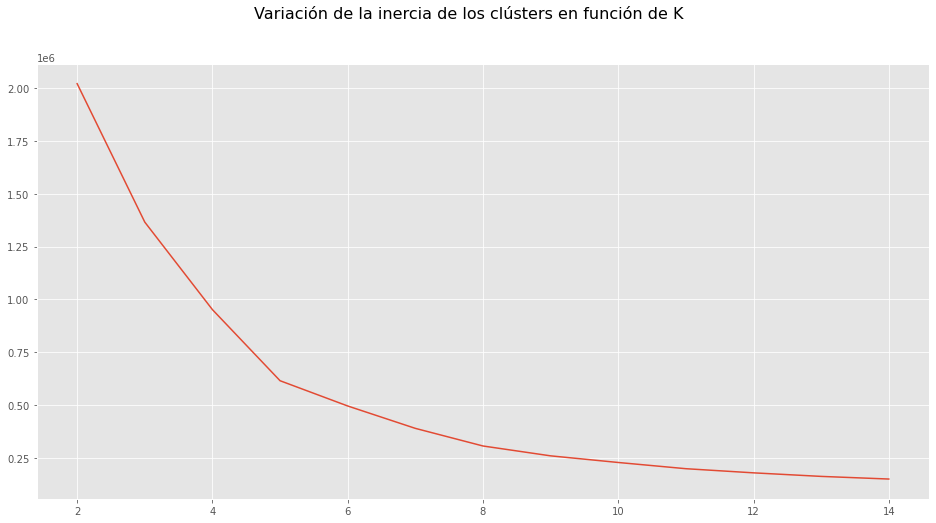

In [621]:
if CALCULATE_ELBOW:
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot()

    x_values = list(sse.keys())
    y_values = list(sse.values())

    ax.plot(x_values, y_values, label = "Inercia de los clústers")
    fig.suptitle("Variación de la inercia de los clústers en función de K", fontsize = 16)

#### Según observamos en la gráfica, los modelos óptimos de segmentación deberían tener 5 u 8 clústers. Vamos a proceder a hacerlo con 7 clústers.

## 2.4 Modelo K-MEANS

In [622]:
cluster_model = KMeans(n_clusters = 7)
cluster_model.fit(scaled_df)

KMeans(n_clusters=7)

In [623]:
labels = cluster_model.predict(scaled_df)
df_final["cluster"] = labels
df_final.head(30)

,Total_products,active_customer,time_since_entry,Total_revenues,account_product,financing_product,saving_product,cluster
pk_cid,,,,,,,,
657826,1.00,1.00,1466,10.00,1,0,0,5
586324,0.00,0.00,514,0.00,0,0,0,0
600525,0.00,1.00,426,0.00,0,0,0,0
556233,0.00,0.00,229,0.00,0,0,0,0
890416,1.00,1.00,261,10.00,1,0,0,3
764944,2.00,1.00,246,20.00,1,0,0,3
876468,0.00,0.00,556,0.00,0,0,0,0
821237,0.00,0.00,515,0.00,0,0,0,0
219746,1.00,1.00,963,60.00,0,1,0,4


In [624]:
# Visualización de clústers:

#selected_columns = ['Total_products', 'salary', 'time_since_entry']
#sns.pairplot(df_final, vars = selected_columns, hue = 'cluster', height=5)

## 2.5 Ficha de clientes segmentados

In [625]:
df_atributtes = df_model_recom[["gender", "age"]].copy()
df_final = pd.merge(df_final, df_atributtes, on="pk_cid")
df_final.head(10)

,Total_products,active_customer,time_since_entry,Total_revenues,account_product,financing_product,saving_product,cluster,gender,age
pk_cid,,,,,,,,,,
657826,1.00,1.00,1466,10.00,1,0,0,5,1,44
586324,0.00,0.00,514,0.00,0,0,0,0,0,36
600525,0.00,1.00,426,0.00,0,0,0,0,1,41
556233,0.00,0.00,229,0.00,0,0,0,0,1,46
890416,1.00,1.00,261,10.00,1,0,0,3,0,40
764944,2.00,1.00,246,20.00,1,0,0,3,1,46
876468,0.00,0.00,556,0.00,0,0,0,0,0,51
821237,0.00,0.00,515,0.00,0,0,0,0,0,38
219746,1.00,1.00,963,60.00,0,1,0,4,1,58


In [626]:
ficha_df = pd.DataFrame()

for i, col in enumerate(["Total_products", "Total_revenues", "time_since_entry", "account_product", "financing_product", "saving_product", "age", "gender"]):
    resumen_data = df_final[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = ficha_df.append(resumen_data)
    
ficha_df.head()

cluster                0    1    2    3    4    5    6
Total_products mean 0.00 1.01 3.31 1.24 3.89 1.35 1.00
               std  0.00 0.07 1.09 0.46 1.63 0.55 0.07
               min  0.00 1.00 1.00 1.00 1.00 1.00 1.00
               25%  0.00 1.00 3.00 1.00 3.00 1.00 1.00
               50%  0.00 1.00 3.00 1.00 4.00 1.00 1.00

In [627]:
# Multiíndice
new_index = ["Total de productos", "Total de ganancias", "Tiempo como cliente", "Producto de cuenta contratado", "Producto de financiación contratado", "Producto de ahorro contratado", "Edad", "Sexo"]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

multi_index = []

for oi in new_index:
    for es in estadisticos:
        multi_index.append((oi, es))
        
multi_index

[('Total de productos', 'Media'),
 ('Total de productos', 'Desviación'),
 ('Total de productos', 'Mínimo'),
 ('Total de productos', 'Perc. 25'),
 ('Total de productos', 'Perc. 50'),
 ('Total de productos', 'Perc. 75'),
 ('Total de productos', 'Máximo'),
 ('Total de ganancias', 'Media'),
 ('Total de ganancias', 'Desviación'),
 ('Total de ganancias', 'Mínimo'),
 ('Total de ganancias', 'Perc. 25'),
 ('Total de ganancias', 'Perc. 50'),
 ('Total de ganancias', 'Perc. 75'),
 ('Total de ganancias', 'Máximo'),
 ('Tiempo como cliente', 'Media'),
 ('Tiempo como cliente', 'Desviación'),
 ('Tiempo como cliente', 'Mínimo'),
 ('Tiempo como cliente', 'Perc. 25'),
 ('Tiempo como cliente', 'Perc. 50'),
 ('Tiempo como cliente', 'Perc. 75'),
 ('Tiempo como cliente', 'Máximo'),
 ('Producto de cuenta contratado', 'Media'),
 ('Producto de cuenta contratado', 'Desviación'),
 ('Producto de cuenta contratado', 'Mínimo'),
 ('Producto de cuenta contratado', 'Perc. 25'),
 ('Producto de cuenta contratado', 'Perc. 

In [628]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [629]:
names = ["Indicador", "Estadísticos"]
index_ficha = generate_multiindex(multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [630]:
tamaño_clusters = df_final.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("Datos Generales", "Tamaño")] , names), inplace = True)

In [631]:
ficha_df = tamaño_clusters.append(ficha_df)
ficha_df

cluster                                                   0         1  \
Indicador                           Estadísticos                        
Datos Generales                     Tamaño       111,342.00 89,070.00   
Total de productos                  Media              0.00      1.01   
                                    Desviación         0.00      0.07   
                                    Mínimo             0.00      1.00   
                                    Perc. 25           0.00      1.00   
                                    Perc. 50           0.00      1.00   
                                    Perc. 75           0.00      1.00   
                                    Máximo             0.00      3.00   
Total de ganancias                  Media              0.00     10.05   
                                    Desviación         0.00      0.71   
                                    Mínimo             0.00     10.00   
                                    Perc. 25           0.00     10.00   
                                    Perc. 50           0.00     10.00   
                                    Perc. 75           0.00     10.00   
                                    Máximo             0.00     30.00   
Tiempo como cliente                 Media            664.30  1,170.74   
                                    Desviación       433.08    195.06   
                                    Mínimo            -2.00    801.00   
                                    Perc. 25         246.00    971.00   
                                    Perc. 50         590.00  1,263.00   
                                    Perc. 75         964.00  1,342.00   
                                    Máximo         1,608.00  1,608.00   
Producto de cuenta contratado       Media              0.00      1.00   
                                    Desviación         0.00      0.00   
                                    Mínimo             0.00      1.00   
                                    Perc. 25           0.00      1.00   
                                    Perc. 50           0.00      1.00   
                                    Perc. 75           0.00      1.00   
                                    Máximo             0.00      1.00   
Producto de financiación contratado Media              0.00      0.00   
                                    Desviación         0.00      0.00   
                                    Mínimo             0.00      0.00   
                                    Perc. 25           0.00      0.00   
                                    Perc. 50           0.00      0.00   
                                    Perc. 75           0.00      0.00   
                                    Máximo             0.00      0.00   
Producto de ahorro contratado       Media              0.00      0.00   
                                    Desviación         0.00      0.00   
                                    Mínimo             0.00      0.00   
                                    Perc. 25           0.00      0.00   
                                    Perc. 50           0.00      0.00   
                                    Perc. 75           0.00      0.00   
                                    Máximo             0.00      0.00   
Edad                                Media             30.79     26.97   
                                    Desviación        13.32      7.35   
                                    Mínimo             2.00      5.00   
                                    Perc. 25          22.00     23.00   
                                    Perc. 50          25.00     25.00   
                                    Perc. 75          37.00     27.00   
                                    Máximo           104.00    105.00   
Sexo                                Media              0.50      0.57   
                                    Desviación         0.50      0.50   
                                    Mínimo             0.0

# 3. RECOMENDACIÓN

### 3.1 Tratamiento de datos

In [632]:
# 1. Definir ventas: aquellos que pasan de 0 a 1. 
# 2. Añadirle las variables tipo shift (tres meses) de tipo de producto.
# 3. Añadir cluster (heredado del ejercicio anterior) aplicado al DF del mes anterior (abril).
# 4. En todo el dataframe, y=venta mayo, x=todo el df de abril (con venta de abril). (venta es tiene producto o no).
# 5. Set others a entry channel.

In [633]:
columnas_prod = products.columns[3:]

In [634]:
# Añado todas las vbles que queremos al dataset de products:
#Calculamos los shifts y Total products
products['Total_products'] = products[columnas_prod].sum(axis=1)

#Añado tipo de productos:
products['account_product'] = products[["em_acount", "em_account_p", "payroll", "debit_card", "payroll_account", "emc_account", "em_account_pp"]].sum(axis=1)
products['financing_product'] = products[['loans', 'mortgage', 'credit_card']].sum(axis=1)
products['saving_product'] = products[["short_term_deposit", "long_term_deposit", "securities", "funds", "pension_plan"]].sum(axis=1)

#Convertimos en int (si tiene uno o más = 1, sino 0)
products['account_product'] = (products['account_product']>0).astype(int)
products['financing_product'] = (products['financing_product']>0).astype(int)
products['saving_product'] = (products['saving_product']>0).astype(int)


In [635]:
# Creo el nuevo dataset en el que se incluirán todos los clientes de mayo, pero con datos de abril:

df_final_3 = products[products['pk_partition']== '2019-05-28'][['pk_cid','account_product','financing_product','saving_product']] #aquí tengo los pk_cid de todos los clientes a analizar + los 3 targets
df_final_3.rename(columns={'account_product':'target_a','financing_product':'target_f','saving_product':'target_s'},inplace=True) #cambio nombre a las columnas para no crear errores, ya que van a ser los targets del árbol

df_final_3 = pd.merge(df_final_3,products[products['pk_partition']== '2019-04-28'],on='pk_cid',how='left') #añado los datos de abril al total de clientes en mayo

df_final_3.drop(['Unnamed: 0','pk_partition'],axis=1,inplace=True) #eliminamos variables que no necesitamos
df_final_3.fillna(0,inplace=True) # Rellenamos los datos con 0 porque al ser nuevos clientes, en el "pasado" estaban todos a 0
df_final_3.set_index('pk_cid',drop=True,inplace=True)

In [636]:
#Añadimos los datos de sociodemo de mayo --> IMPORTANTE: ESTAS VBLES NO DEBERÍAN CAMBIAR CON EL TIEMPO y nos ayuda a saber datos sociodemográficos del cliente, ademas incluye los clientes nuevos de abril a mayo

sociodemo_recom = sociodemo[sociodemo['pk_partition']== '2019-05-28'] #la fecha es de mayo para incluir los nuevos clientes, ya que estas vbles no deberían cambiar significativamente
sociodemo_recom.drop(['Unnamed: 0','pk_partition'],axis=1,inplace=True)
sociodemo_recom.set_index('pk_cid',inplace=True,drop=True)

#mujeres =1, hombres =0
sociodemo_recom['gender'] = (sociodemo_recom['gender']=='H').astype(int)

#PASA ALGO RARO CON LA REGION CODE 52 --> PREGUNTAR MA PARRADO

#Añadimos vbles socioeconomicas
sociodemo_recom = pd.merge(sociodemo_recom, extra_features_df, on="region_code", right_index=True,how='left') #Aquí van las vles de PIB per cápita, paro.... etc

df_final_3 = pd.merge(df_final_3,sociodemo_recom,on='pk_cid',how='left')


In [637]:
#Quitamos los fallecidos y eliminamos vbles que no usemos
df_final_3 = df_final_3[df_final_3['deceased']=='N']
df_final_3.drop(['deceased','country_id','region_code'],axis=1,inplace=True)

In [638]:
#Añadimos vbles de commercial

commercial_recom = commercial[commercial['pk_partition']== '2019-04-28'] #Añadimos los datos comerciales de abril y los de los clientes de mayo aparecerán a 0
commercial_recom.set_index('pk_cid',drop=True,inplace=True)
commercial_recom.drop(['Unnamed: 0','pk_partition','segment'],axis=1,inplace=True)

df_final_3 = pd.merge(df_final_3,commercial_recom,on='pk_cid',how='left')

In [639]:
# Sustituimos fechas erróneas de la variable entry_date:

df_final_3.loc[df_final_3['entry_date'] == '2019-02-29', 'entry_date'] = '2019-02-28'
df_final_3.loc[df_final_3['entry_date'] == '2015-02-29', 'entry_date'] = '2015-02-28'

#convertimos entry_date a datetime:
df_final_3['entry_date'] = pd.to_datetime(df_final_3['entry_date'], format = '%Y-%m-%d')

In [640]:
df_final_3['date_recom'] = '2019-04-28'
df_final_3['date_recom'] = pd.to_datetime(df_final_3['date_recom'], format = '%Y-%m-%d')
df_final_3['time_since_entry'] =  df_final_3['date_recom'] - df_final_3['entry_date']
df_final_3.drop(["date_recom", "entry_date"], axis= 1, inplace=True)

In [641]:
#función para asignar la categoría Others

def set_others(df,column, num_values):
    top_browsers = df[column].value_counts().head(num_values)
    top_browsers_list = top_browsers.index.to_list()
    top_browsers_list.append('Others')
    return pd.Categorical(df[column], categories=top_browsers_list).fillna('Others')

In [642]:
df_final_3['entry_channel']=set_others(df_final_3,'entry_channel',6)

In [643]:
df_final_3['entry_channel'].value_counts(normalize=True)

KHE      0.44
KHQ      0.17
KFC      0.13
Others   0.10
KHM      0.06
KAT      0.06
KHK      0.04
Name: entry_channel, dtype: float64

In [644]:
# Aplicamos un OHE a la variable entry_channel"

def OneHotEncoderFunction(df, column_name):
    _dummy_dataset=pd.get_dummies(df[column_name], prefix=column_name)
    df=pd.concat([df, _dummy_dataset], axis=1)
    df.drop(column_name, axis=1, inplace=True)
    return df

In [645]:
df_final_3 = OneHotEncoderFunction(df_final_3,'entry_channel')

In [646]:
#Añadimos el cluster de '2019-04-28':

#Total_revenues:
df_final_3['Total_revenues'] = df_final_3[["em_acount", "em_account_p", "debit_card", "payroll_account", "emc_account", "em_account_pp"]].sum(axis=1)*10 + df_final_3[['loans', 'mortgage', 'credit_card']].sum(axis=1)*60 + df_final_3[["short_term_deposit", "long_term_deposit", "securities", "funds", "pension_plan"]].sum(axis=1)*40

df_cluster_recom = df_final_3[['Total_products','active_customer','time_since_entry','Total_revenues','account_product','financing_product','saving_product']].copy(deep=True) #definimos el DF para colocar las labels del cluster

In [647]:
df_cluster_recom['time_since_entry'] =df_cluster_recom['time_since_entry'].dt.days
df_cluster_recom['time_since_entry'] =df_cluster_recom['time_since_entry'].astype(float) #cambiamos los dias a float para poder usar el standard_scaler

In [648]:
df_cluster_recom.isnull().sum()

Total_products          0
active_customer      4588
time_since_entry     4588
Total_revenues          0
account_product         0
financing_product       0
saving_product          0
dtype: int64

In [649]:
df_cluster_recom.fillna(0,inplace=True) #ponemos las variables nulas a 0, porque es el valor que les corresponden al ser nuevos clientes

In [650]:
df_cluster_recom.isnull().sum()

Total_products       0
active_customer      0
time_since_entry     0
Total_revenues       0
account_product      0
financing_product    0
saving_product       0
dtype: int64

In [651]:
#escalamos el df para poder hacerle el cluster:

scaled_df_recom = standard_scaler.fit_transform(df_cluster_recom)

labels_recom = cluster_model.predict(scaled_df_recom)
df_final_3["cluster"] = labels_recom


In [652]:
#Calculamos los shifts

#1 mes atras
mes_1 = products[products['pk_partition']=='2019-03-28'][['account_product','financing_product','saving_product','Total_products','pk_cid']]
mes_1.set_index('pk_cid',inplace=True,drop=True)
#2 meses atras
mes_2 = products[products['pk_partition']=='2019-02-28'][['account_product','financing_product','saving_product','Total_products','pk_cid']]
mes_2.set_index('pk_cid',inplace=True,drop=True)
#3 meses atras
mes_3 = products[products['pk_partition']=='2019-01-28'][['account_product','financing_product','saving_product','Total_products','pk_cid']]
mes_3.set_index('pk_cid',inplace=True,drop=True)


In [653]:
mes_1.rename(columns={'account_product':'account_product_1','financing_product':'financing_product_1','saving_product':'saving_product_1','Total_products':'Total_products_1'},inplace=True)

mes_2.rename(columns={'account_product':'account_product_2','financing_product':'financing_product_2','saving_product':'saving_product_2','Total_products':'Total_products_2'},inplace=True)

mes_3.rename(columns={'account_product':'account_product_3','financing_product':'financing_product_3','saving_product':'saving_product_3','Total_products':'Total_products_3'},inplace=True)

In [654]:
#Añadimos los shift

df_final_3 = pd.merge(df_final_3,mes_1[['account_product_1','financing_product_1','saving_product_1','Total_products_1']],on='pk_cid',how='left')
df_final_3 = pd.merge(df_final_3,mes_2[['account_product_2','financing_product_2','saving_product_2','Total_products_2']],on='pk_cid',how='left')
df_final_3 = pd.merge(df_final_3,mes_3[['account_product_3','financing_product_3','saving_product_3','Total_products_3']],on='pk_cid',how='left')



In [655]:
#CALCULAMOS LAS VENTAS

df_final_3['v_a'] = ((df_final_3['account_product']==0) & (df_final_3['target_a']>0)).astype(int)

df_final_3['v_f'] = ((df_final_3['financing_product']==0) & (df_final_3['target_f']>0)).astype(int)

df_final_3['v_s'] = ((df_final_3['saving_product']==0) & (df_final_3['target_s']>0)).astype(int)

In [656]:
# Borramos las variables que no necesitamos:

df_final_3.drop(['target_a','target_f','target_s','short_term_deposit','loans','mortgage','funds','securities','long_term_deposit','em_account_pp','credit_card','payroll','pension_plan','payroll_account','emc_account','debit_card','em_account_p','em_acount'],axis=1,inplace=True)

#se deja Total_products?? --> es del mes de abril, así que no hay target leakage

In [657]:
df_final_3.head().T

pk_cid,657826,657817,657986,657905,657336
Total_products,1.00,0.00,6.00,2.00,1.00
account_product,1.00,0.00,1.00,1.00,1.00
financing_product,0.00,0.00,1.00,0.00,0.00
saving_product,0.00,0.00,1.00,1.00,0.00
gender,1,0,1,1,0
age,44,32,39,85,38
salary,"54,493.38",NaN,"100,993.17","154,059.09",NaN
PIB_per_capita,"21,153.00","28,015.00","22,120.00","20,415.00","20,415.00"
Salario_medio,"1,880.92","1,958.40","1,889.08","1,880.92","1,880.92"
Población,"389,874.00","220,607.00","306,872.00","262,409.00","262,409.00"


In [658]:
df_final_3.isnull().sum()

Total_products               0
account_product              0
financing_product            0
saving_product               0
gender                       0
age                          0
salary                  147697
PIB_per_capita             161
Salario_medio              161
Población                  161
Tasa_desempleo             161
active_customer           4588
time_since_entry          4588
entry_channel_KHE            0
entry_channel_KHQ            0
entry_channel_KFC            0
entry_channel_KHM            0
entry_channel_KAT            0
entry_channel_KHK            0
entry_channel_Others         0
Total_revenues               0
cluster                      0
account_product_1         8804
financing_product_1       8804
saving_product_1          8804
Total_products_1          8804
account_product_2        13916
financing_product_2      13916
saving_product_2         13916
Total_products_2         13916
account_product_3        19481
financing_product_3      19481
saving_p

In [659]:
#imputamos los nulos:

df_final_3['salary'].fillna(df_final_3['salary'].mean(),inplace=True)
df_final_3['PIB_per_capita'].fillna(df_final_3['PIB_per_capita'].mean(),inplace=True)
df_final_3['Salario_medio'].fillna(df_final_3['Salario_medio'].mean(),inplace=True)
df_final_3['Población'].fillna(df_final_3['Población'].mean(),inplace=True)
df_final_3['Tasa_desempleo'].fillna(df_final_3['Tasa_desempleo'].mean(),inplace=True)


In [660]:
#antes modificar time_since_entry:
df_final_3['time_since_entry'] =df_final_3['time_since_entry'].dt.days
df_final_3['time_since_entry'] =df_final_3['time_since_entry'].astype(float)

# el resto de nulos serán 0
df_final_3.fillna(0,inplace=True)

In [661]:
#TODO LIMPIO DE NULOS
df_final_3.isnull().sum()

Total_products          0
account_product         0
financing_product       0
saving_product          0
gender                  0
age                     0
salary                  0
PIB_per_capita          0
Salario_medio           0
Población               0
Tasa_desempleo          0
active_customer         0
time_since_entry        0
entry_channel_KHE       0
entry_channel_KHQ       0
entry_channel_KFC       0
entry_channel_KHM       0
entry_channel_KAT       0
entry_channel_KHK       0
entry_channel_Others    0
Total_revenues          0
cluster                 0
account_product_1       0
financing_product_1     0
saving_product_1        0
Total_products_1        0
account_product_2       0
financing_product_2     0
saving_product_2        0
Total_products_2        0
account_product_3       0
financing_product_3     0
saving_product_3        0
Total_products_3        0
v_a                     0
v_f                     0
v_s                     0
dtype: int64

In [662]:
#CALCULO DE 12MESES SIN PRODUCTO

products['saving_product'] = products[['short_term_deposit', 'funds', 'securities', 'long_term_deposit', 'pension_plan']].sum(axis=1)
products['financing_product'] = products[['loans', 'mortgage', 'credit_card']].sum(axis=1)
products['account_product'] = products[['em_account_pp', 'payroll', 'payroll_account', 'debit_card', 'emc_account','em_account_p','em_acount']].sum(axis=1)

products_now = products[products['pk_partition']== '2019-05-28']
products_now.set_index("pk_cid", inplace=True)
productos_tipo = products_now[['saving_product','financing_product','account_product']]

In [663]:
fechas = ['2019-05-28','2019-04-28','2019-03-28','2019-02-28','2019-01-28','2018-12-28','2018-11-28','2018-10-28','2018-09-28','2018-08-28','2018-07-28','2018-06-28']
lista_tipo_prod = ['saving_product','financing_product','account_product']

In [664]:
for a in productos_tipo:
    i=0
    for j in fechas:
        i+=1
        productos_tipo[str(a)+'_'+str(i)] = products[products['pk_partition']==j][str(a)]

productos_tipo.fillna(0,inplace=True)

In [665]:
productos_tipo['12m_saving'] = (productos_tipo[productos_tipo.columns[3:15]].sum(axis=1)>0).astype(int)
productos_tipo['12m_financing'] = (productos_tipo[productos_tipo.columns[15:27]].sum(axis=1)>0).astype(int)
productos_tipo['12m_account'] = (productos_tipo[productos_tipo.columns[27:]].sum(axis=1)>0).astype(int)

Vbles para el árbol: cluster, familia producto, total products, shift (de 1 a 3) de otros productos. Time since entry, 

Añadir clientes nuevos de abril a mayo.

In [666]:
from sklearn import tree
from sklearn.model_selection import train_test_split

In [667]:
df_final_3 = OneHotEncoderFunction(df_final_3,'cluster')

In [668]:
df_final_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442909 entries, 657826 to 1550586
Data columns (total 43 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Total_products        442909 non-null  float64
 1   account_product       442909 non-null  float64
 2   financing_product     442909 non-null  float64
 3   saving_product        442909 non-null  float64
 4   gender                442909 non-null  int64  
 5   age                   442909 non-null  int64  
 6   salary                442909 non-null  float64
 7   PIB_per_capita        442909 non-null  float64
 8   Salario_medio         442909 non-null  float64
 9   Población             442909 non-null  float64
 10  Tasa_desempleo        442909 non-null  float64
 11  active_customer       442909 non-null  float64
 12  time_since_entry      442909 non-null  float64
 13  entry_channel_KHE     442909 non-null  uint8  
 14  entry_channel_KHQ     442909 non-null  uint8  

### 3.2 AHORRO-INVERSIÓN

Seleccionamos el dataset para el primer modelo.

Dentro del dataset completo de clientes, escogemos los clientes que tienen algún tipo de producto:

In [669]:
# elegiremos dentro de nuestro data set, los clientes del mes de abril + los nuevos clientes:

Tasa positiva mayor del 5%

In [670]:
# Como las ventas de savings son 2812, elegimos un data seet de no ventas de 50000 para que la tasa positiva supere el 5%

df_samp = df_final_3[((df_final_3['saving_product']==0) & (df_final_3['Total_products']>0) &(df_final_3['v_s']==0))]
df_samp_s = df_samp.sample(n=50000,random_state=RANDOM_STATE)


In [671]:
lista_concat = [df_final_3[df_final_3['v_s']==1],df_samp_s]
df_s = pd.concat(list([df_final_3[df_final_3['v_s']==1],df_samp_s]))
df_s['v_s'].mean()*100

5.324547451336818

In [672]:
df_s.head().T

pk_cid,672927,669958,633548,722137,736519
Total_products,3.00,3.00,0.00,1.00,2.00
account_product,1.00,1.00,0.00,1.00,1.00
financing_product,0.00,0.00,0.00,0.00,0.00
saving_product,0.00,0.00,0.00,0.00,0.00
gender,1.00,1.00,0.00,1.00,0.00
age,48.00,29.00,52.00,44.00,32.00
salary,"66,522.63","155,519.10","116,675.94","82,225.35","164,502.75"
PIB_per_capita,"20,415.00","20,415.00","18,181.00","20,415.00","20,415.00"
Salario_medio,"1,880.92","1,880.92","1,773.03","1,880.92","1,880.92"
Población,"262,409.00","262,409.00","925,160.00","262,409.00","262,409.00"


In [673]:
#Separación de train, test y validation

df_s_X = df_s.drop(['v_a','v_f','v_s'],axis=1)
df_s_y = df_s[['v_s']]

X_s_dev, X_s_val, y_s_dev, y_s_val = train_test_split(df_s_X,df_s_y, test_size=0.2, random_state=RANDOM_STATE)
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s_dev,y_s_dev, test_size=0.2, random_state=RANDOM_STATE)

In [674]:
def Depth_mod(X_train,y_train,X_test,y_test):
    for i in range(1, 20):
        dt = DecisionTreeClassifier(max_depth=i, random_state=42)
        dt.fit(X_train, y_train)
        train_accuracy = dt.score(X_train, y_train)
        test_accuracy = dt.score(X_test, y_test)
        print('Profundidad del árbol: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))


Buscamos una profundidad buena de árbol

In [675]:
Depth_mod(X_s_train,y_s_train,X_s_test,y_s_test)

Profundidad del árbol: 1. Train: 0.9632237640166869 - Test: 0.9628402366863905
Profundidad del árbol: 2. Train: 0.9660344980620729 - Test: 0.9659171597633136
Profundidad del árbol: 3. Train: 0.9661232580845587 - Test: 0.9662721893491124
Profundidad del árbol: 4. Train: 0.96659664487115 - Test: 0.9641420118343196
Profundidad del árbol: 5. Train: 0.9669516849610935 - Test: 0.9648520710059172
Profundidad del árbol: 6. Train: 0.9677505251634664 - Test: 0.9653254437869823
Profundidad del árbol: 7. Train: 0.9684901920175153 - Test: 0.9654437869822485
Profundidad del árbol: 8. Train: 0.9692298588715642 - Test: 0.9653254437869823
Profundidad del árbol: 9. Train: 0.9704429125122045 - Test: 0.9650887573964497
Profundidad del árbol: 10. Train: 0.9713600994112251 - Test: 0.965207100591716
Profundidad del árbol: 11. Train: 0.9726914997485133 - Test: 0.961301775147929
Profundidad del árbol: 12. Train: 0.9743779401757449 - Test: 0.9621301775147929
Profundidad del árbol: 13. Train: 0.9760347939288144 

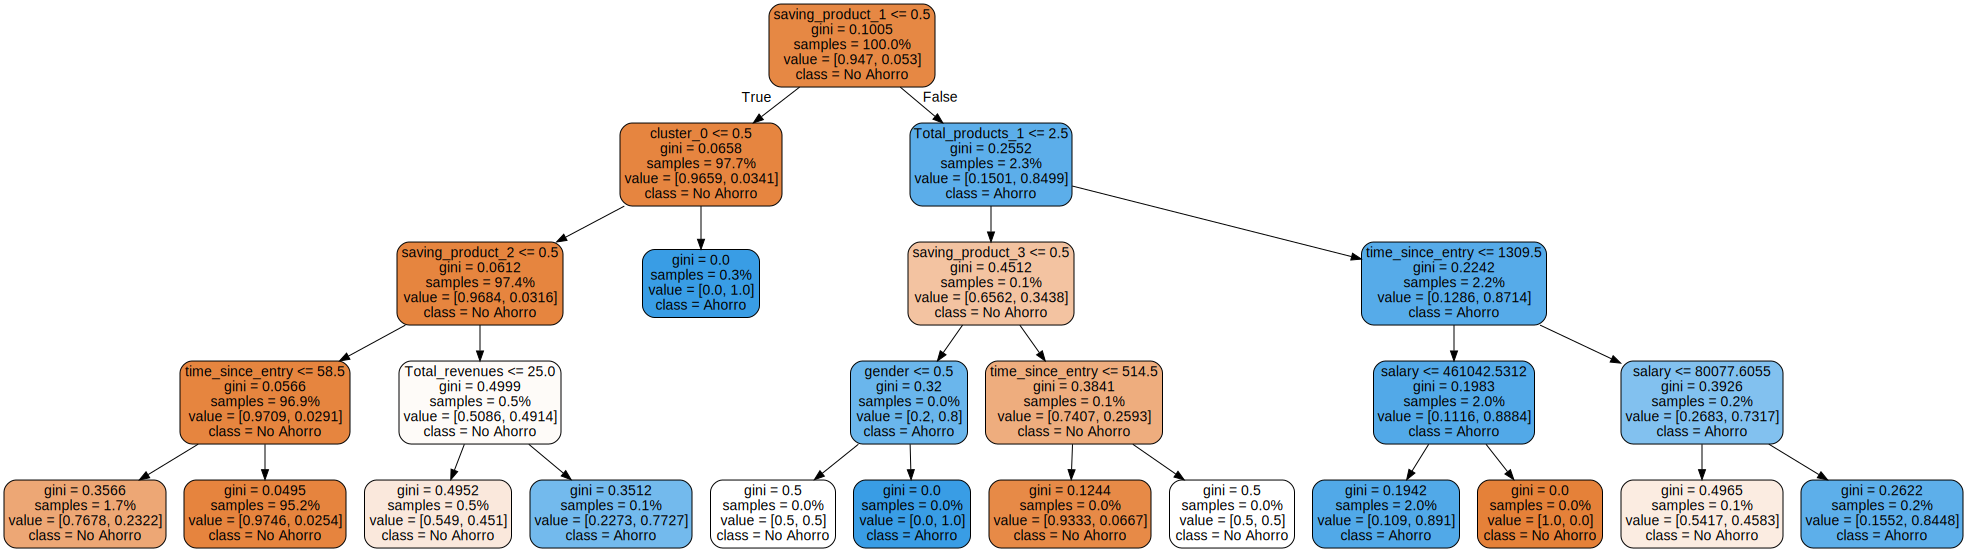

<Figure size 576x576 with 0 Axes>

In [676]:
dt = DecisionTreeClassifier(max_depth=4, random_state=42)

plt.figure(figsize=(8,8))
dot_data = export_graphviz(
                        decision_tree = dt.fit(X_s_train,y_s_train),
                        feature_names=X_s_test.columns,
                        class_names=['No Ahorro', 'Ahorro'],
                        filled=True,
                        impurity=True,
                        proportion=True,
                        rotate=False,
                        rounded=True,
                        precision=4,
                        )

graph = graphviz.Source(dot_data)
graph

Elegimos la profundidad de 8 y probamos que modelo va mejor:

In [677]:
def Model_elect(Random_state,n_depth,X_train,y_train,X_test,y_test):
    #n_estimators = 50
    plt.figure(figsize=(15,8))

    models = [ 
        ('DecisionTree', DecisionTreeClassifier(max_depth=n_depth, random_state=42)),
        ('RandomForest', RandomForestClassifier(max_depth=n_depth, random_state=RANDOM_STATE)),
        ('GradientBoosting', GradientBoostingClassifier(max_depth=n_depth, random_state=RANDOM_STATE))
    ]
    plt.clf()
    for model in models:
        model_name = model[0]
        model_instance = model[1]
        model_instance.fit(X_train, np.ravel(y_train))
        predictions = model_instance.predict_proba(X_test)[:,1]
        auc_score = metrics.roc_auc_score(y_test, predictions)
        print('ROC AUC Score for {}: {}'.format(model_name, auc_score))
        fpr, tpr, _ = metrics.roc_curve(y_test, predictions)
        plt.plot(fpr, tpr, label='ROC Curve for {} - Area: {:2f}'.format(model_name, auc_score))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc="lower right")
    plt.title('ROC curve')
    plt.show()


ROC AUC Score for DecisionTree: 0.8731414551677215
ROC AUC Score for RandomForest: 0.9158999099712046
ROC AUC Score for GradientBoosting: 0.914848703516621


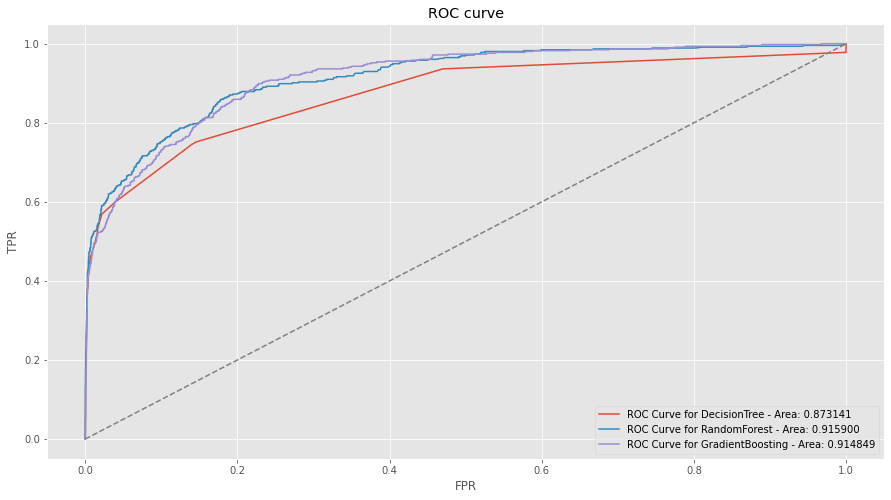

In [678]:
Model_elect(RANDOM_STATE,7,X_s_train,y_s_train,X_s_test,y_s_test)

Nos quedamos con GradientBoosting y comprobamos la métrica de validación:

In [679]:
GB_s = GradientBoostingClassifier(max_depth=7, random_state=RANDOM_STATE)

In [680]:
def Validacion(modelo,X_train,y_train,X_val,y_val):
    modelo.fit(X_train,y_train)
    
    score_ = modelo.score(X_val,y_val)
    print("Score val: {}".format(score_))
    print('\n ------- \n')    
    score_ROC = metrics.roc_auc_score(y_val, modelo.predict_proba(X_val)[:,1])
    print("Score AU ROC val: {}".format(score_ROC))


In [681]:
Validacion(GB_s,X_s_train,y_s_train,X_s_val,y_s_val)

Score val: 0.9647827321783584

 ------- 

Score AU ROC val: 0.9078844941231712


### 3.3 FINANCIACIÓN

In [682]:
df_final_3[df_final_3['v_f']>0].shape
#Elegimos un sample de 14.3k para que sea más del 5%

(758, 43)

In [683]:
df_samp = df_final_3[((df_final_3['financing_product']==0) & (df_final_3['Total_products']>0) &(df_final_3['v_f']==0))]
df_samp_f = df_samp.sample(n=14300,random_state=RANDOM_STATE)

df_f = pd.concat(list([df_final_3[df_final_3['v_f']==1],df_samp_f]))
df_f['v_f'].mean()*100

5.033869039713109

In [684]:
df_f_X = df_f.drop(['v_a','v_f','v_s'],axis=1)
df_f_y = df_f[['v_f']]

X_f_dev, X_f_val, y_f_dev, y_f_val = train_test_split(df_f_X,df_f_y, test_size=0.2, random_state=RANDOM_STATE)
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_f_dev,y_f_dev, test_size=0.2, random_state=RANDOM_STATE)

In [685]:
Depth_mod(X_f_train,y_f_train,X_f_test,y_f_test)

Profundidad del árbol: 1. Train: 0.9659609796596098 - Test: 0.9643153526970955
Profundidad del árbol: 2. Train: 0.9701120797011208 - Test: 0.9705394190871369
Profundidad del árbol: 3. Train: 0.9704234122042341 - Test: 0.9705394190871369
Profundidad del árbol: 4. Train: 0.9734329597343296 - Test: 0.9738589211618257
Profundidad del árbol: 5. Train: 0.9743669572436696 - Test: 0.9738589211618257
Profundidad del árbol: 6. Train: 0.9755085097550851 - Test: 0.9730290456431535
Profundidad del árbol: 7. Train: 0.9763387297633873 - Test: 0.9734439834024896
Profundidad del árbol: 8. Train: 0.9774802822748028 - Test: 0.9713692946058091
Profundidad del árbol: 9. Train: 0.9787256122872561 - Test: 0.9717842323651452
Profundidad del árbol: 10. Train: 0.9804898298048983 - Test: 0.9705394190871369
Profundidad del árbol: 11. Train: 0.9823578248235783 - Test: 0.9713692946058091
Profundidad del árbol: 12. Train: 0.9845371523453715 - Test: 0.9721991701244813
Profundidad del árbol: 13. Train: 0.9869240348692

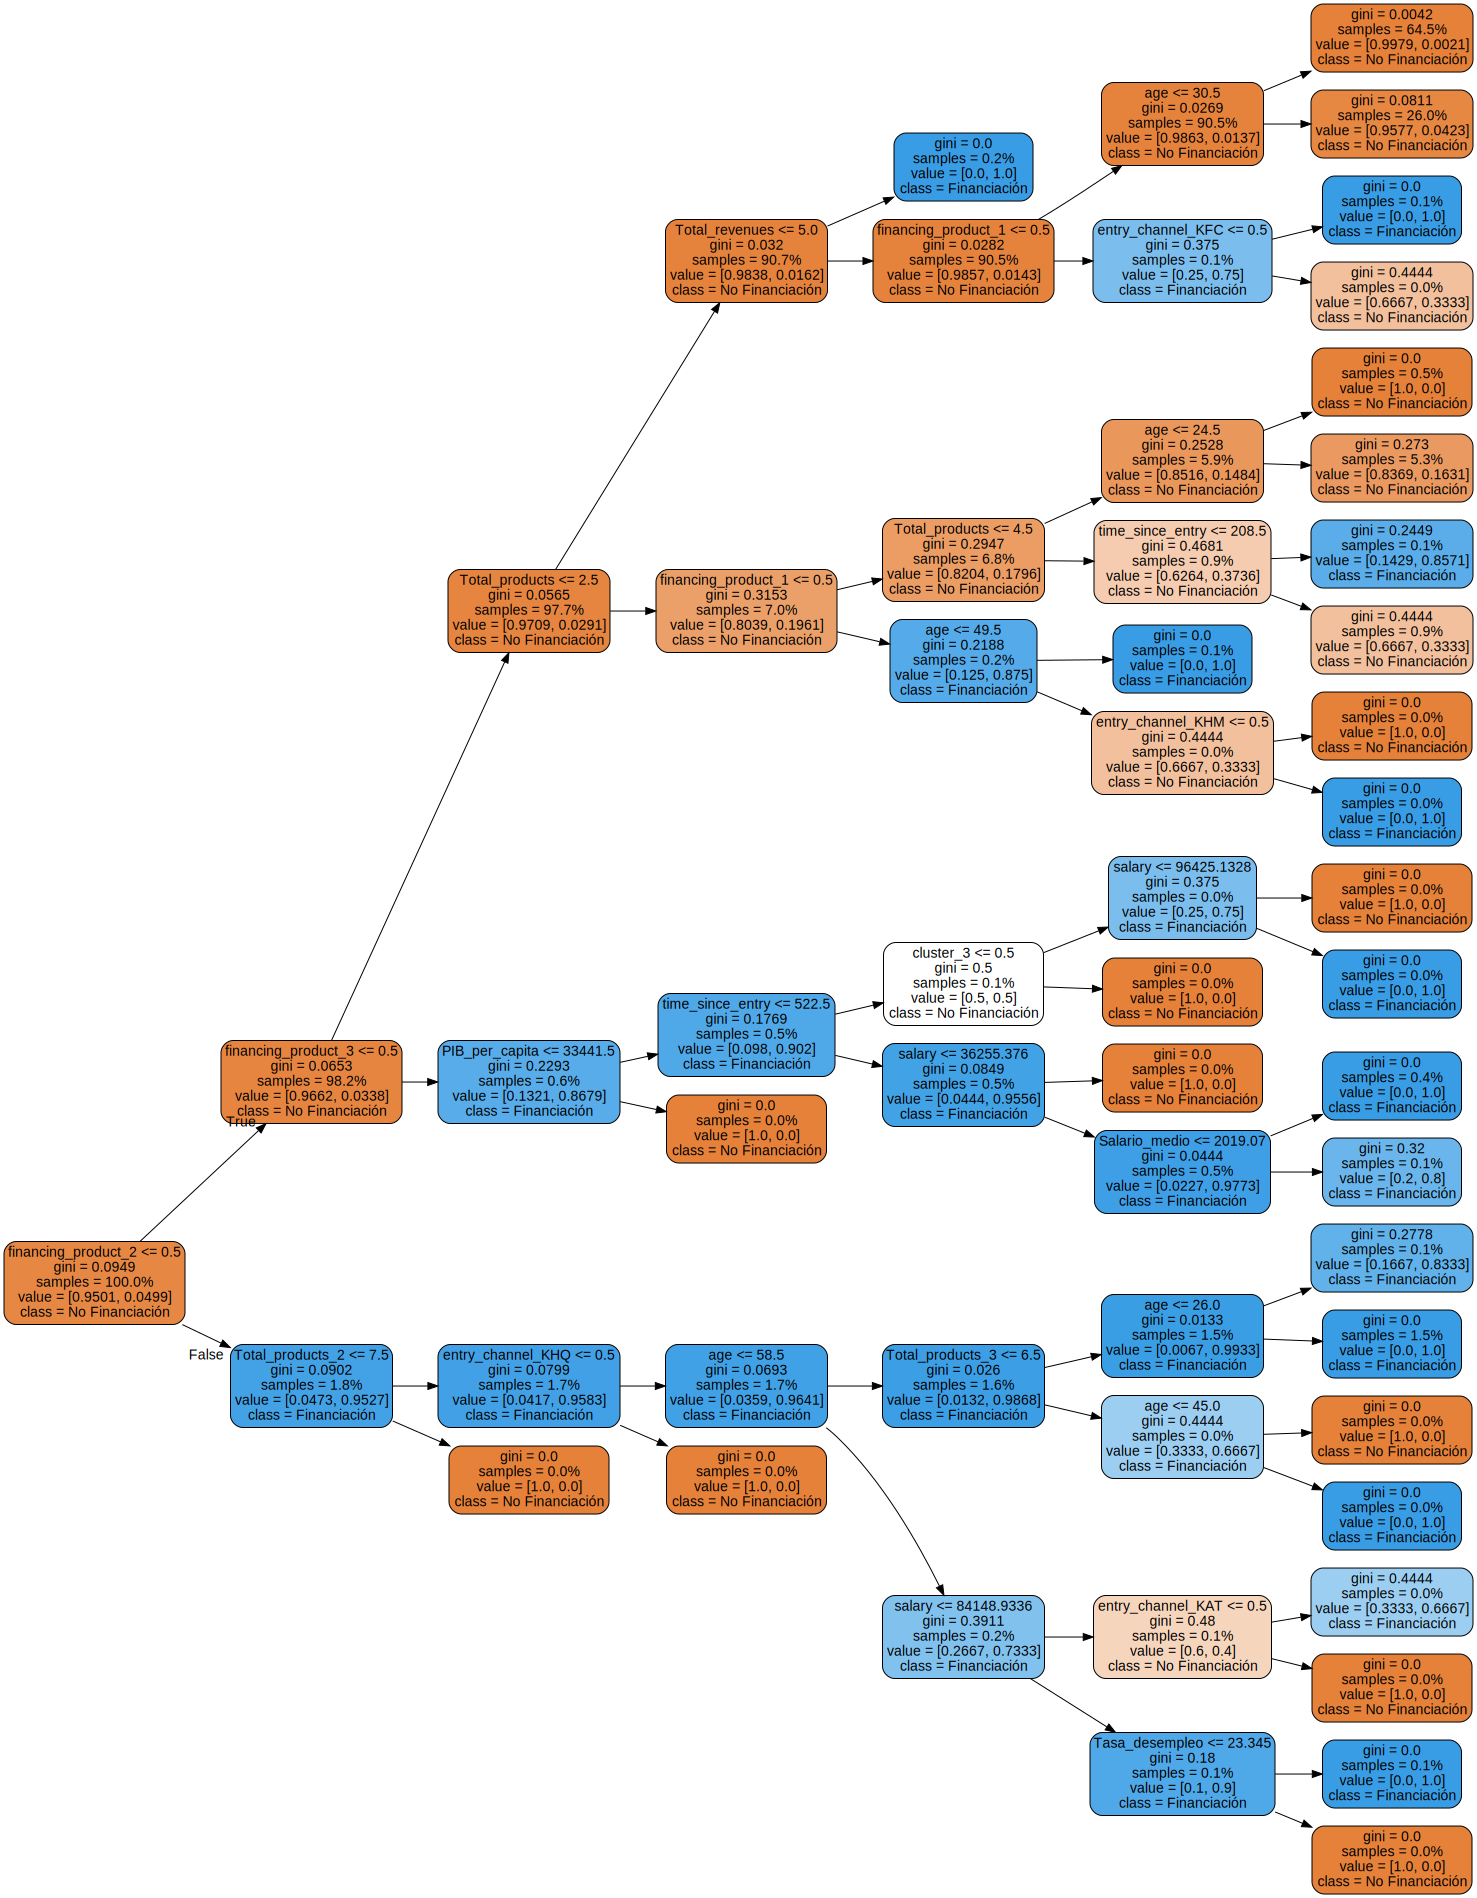

<Figure size 576x576 with 0 Axes>

In [686]:
dt = DecisionTreeClassifier(max_depth=6, random_state=42)

plt.figure(figsize=(8,8))
dot_data = export_graphviz(
                        decision_tree = dt.fit(X_f_train,y_f_train),
                        feature_names=X_f_test.columns,
                        class_names=['No Financiación', 'Financiación'],
                        filled=True,
                        impurity=True,
                        proportion=True,
                        rotate=True,
                        rounded=True,
                        precision=4,
                        )

graph = graphviz.Source(dot_data)
graph

Elegimos 7 como profundidad máxima

ROC AUC Score for DecisionTree: 0.8877913597775609
ROC AUC Score for RandomForest: 0.9466382701807318
ROC AUC Score for GradientBoosting: 0.9467029757150887


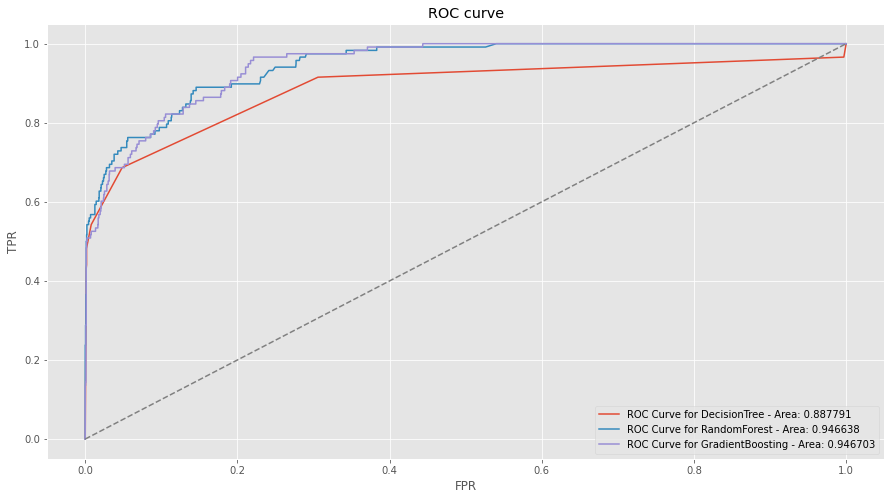

In [687]:
Model_elect(RANDOM_STATE,6,X_f_train,y_f_train,X_f_test,y_f_test)

In [688]:
GB_f = GradientBoostingClassifier(max_depth=6, random_state=RANDOM_STATE)

In [689]:
Validacion(GB_f,X_f_train,y_f_train,X_f_val,y_f_val)

Score val: 0.9691235059760956

 ------- 

Score AU ROC val: 0.9468924909672485


### 3.4 CUENTAS

In [690]:
df_final_3[df_final_3['v_a']>0].shape #Elegimos un data set de 73k registros

(3889, 43)

In [691]:
df_a = df_final_3[(df_final_3['account_product']==0) & (df_final_3['v_a']==0)]
df_samp_a = df_final_3[(df_final_3['account_product']==0) & (df_final_3['v_a']==0)]
df_samp_a = df_samp_a.sample(n=73000,random_state=RANDOM_STATE)

df_a= pd.concat(list([df_samp_a,df_final_3[df_final_3['v_a']>0]]))

df_a['v_a'].mean()*100

5.0579406677157985

In [692]:
df_a_X = df_a.drop(['v_a','v_f','v_s'],axis=1)
df_a_y = df_a[['v_a']]

X_a_dev, X_a_val, y_a_dev, y_a_val = train_test_split(df_a_X,df_a_y, test_size=0.2, random_state=RANDOM_STATE)
X_a_train, X_a_test, y_a_train, y_a_test = train_test_split(X_a_dev,y_a_dev, test_size=0.2, random_state=RANDOM_STATE)

In [693]:
Depth_mod(X_a_train,y_a_train,X_a_test,y_a_test)

Profundidad del árbol: 1. Train: 0.9492562185010568 - Test: 0.9467609526131838
Profundidad del árbol: 2. Train: 0.9492562185010568 - Test: 0.9467609526131838
Profundidad del árbol: 3. Train: 0.9492562185010568 - Test: 0.9467609526131838
Profundidad del árbol: 4. Train: 0.9503739229393594 - Test: 0.9478988864504593
Profundidad del árbol: 5. Train: 0.9506381076247764 - Test: 0.9476550434853288
Profundidad del árbol: 6. Train: 0.9530157697935295 - Test: 0.9498496301715029
Profundidad del árbol: 7. Train: 0.9542757275239798 - Test: 0.949361944241242
Profundidad del árbol: 8. Train: 0.9557592261420907 - Test: 0.949361944241242
Profundidad del árbol: 9. Train: 0.9576491627377662 - Test: 0.9477363244737056
Profundidad del árbol: 10. Train: 0.9602503657941798 - Test: 0.9487116963342275
Profundidad del árbol: 11. Train: 0.9630954316371322 - Test: 0.9487929773226043
Profundidad del árbol: 12. Train: 0.9652901967159812 - Test: 0.9483865723807201
Profundidad del árbol: 13. Train: 0.968114940660055

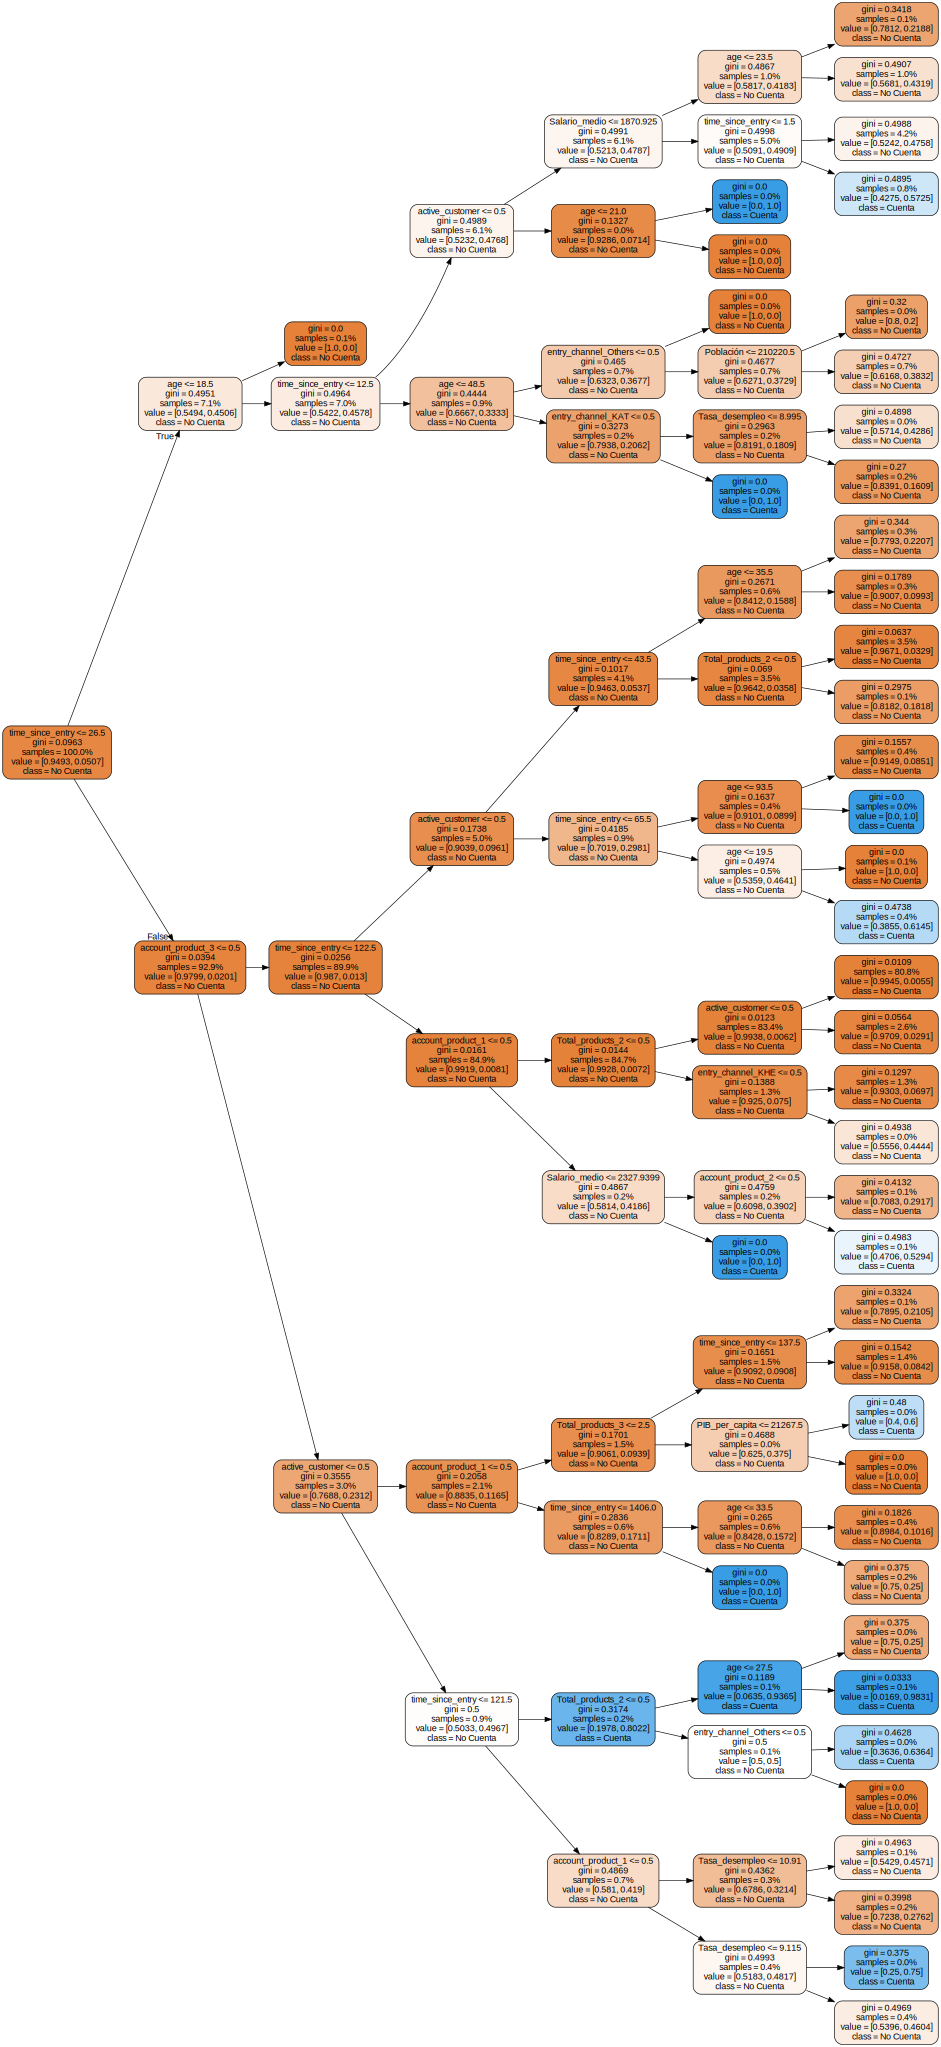

<Figure size 576x576 with 0 Axes>

In [694]:
dt = DecisionTreeClassifier(max_depth=6, random_state=42)

plt.figure(figsize=(8,8))
dot_data = export_graphviz(
                        decision_tree = dt.fit(X_a_train,y_a_train),
                        feature_names=X_a_test.columns,
                        class_names=['No Cuenta', 'Cuenta'],
                        filled=True,
                        impurity=True,
                        proportion=True,
                        rotate=True,
                        rounded=True,
                        precision=4,
                        )

graph = graphviz.Source(dot_data)
graph

ROC AUC Score for DecisionTree: 0.9089235251866454
ROC AUC Score for RandomForest: 0.9208717153552555
ROC AUC Score for GradientBoosting: 0.9232970571889942


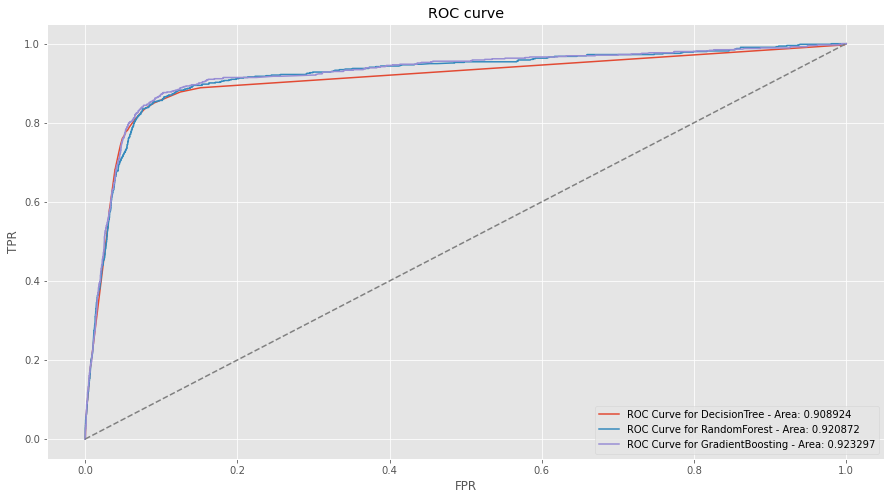

In [695]:
Model_elect(RANDOM_STATE,6,X_a_train,y_a_train,X_a_test,y_a_test)

In [696]:
GB_a = GradientBoostingClassifier(max_depth=6, random_state=RANDOM_STATE)

In [697]:
Validacion(GB_a,X_a_train,y_a_train,X_a_val,y_a_val)

Score val: 0.9555859019378332

 ------- 

Score AU ROC val: 0.9347437638415641


### 3.5 Cálculo de probabilidad

Montamos el dataset que incorporará a nuestra cartera de clientes, aquellos que no tengan todavía algún tipo de producto ofertado.

In [698]:
df_final.info() #Para calcular la probabilidad lo haremos sobre el DF con los clientes de mayo

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442748 entries, 657826 to 1166773
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Total_products     442748 non-null  float64
 1   active_customer    442748 non-null  float64
 2   time_since_entry   442748 non-null  int64  
 3   Total_revenues     442748 non-null  float64
 4   account_product    442748 non-null  int64  
 5   financing_product  442748 non-null  int64  
 6   saving_product     442748 non-null  int64  
 7   cluster            442748 non-null  int32  
 8   gender             442748 non-null  int64  
 9   age                442748 non-null  int64  
dtypes: float64(3), int32(1), int64(6)
memory usage: 35.5 MB


In [699]:
df_final_3.info() # Hay que añadirle más variables para que pueda llegar a tener las mismas variables que df_final_3

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442909 entries, 657826 to 1550586
Data columns (total 43 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Total_products        442909 non-null  float64
 1   account_product       442909 non-null  float64
 2   financing_product     442909 non-null  float64
 3   saving_product        442909 non-null  float64
 4   gender                442909 non-null  int64  
 5   age                   442909 non-null  int64  
 6   salary                442909 non-null  float64
 7   PIB_per_capita        442909 non-null  float64
 8   Salario_medio         442909 non-null  float64
 9   Población             442909 non-null  float64
 10  Tasa_desempleo        442909 non-null  float64
 11  active_customer       442909 non-null  float64
 12  time_since_entry      442909 non-null  float64
 13  entry_channel_KHE     442909 non-null  uint8  
 14  entry_channel_KHQ     442909 non-null  uint8  

In [700]:
df_prob = df_final.copy(deep=True) #se pueden añadir los datos demográficos, porque serán los mismos
df_prob = pd.merge(df_prob,df_final_3[['salary','PIB_per_capita','Salario_medio','Población','Tasa_desempleo']],on='pk_cid',how='left')

In [701]:
#Añadimos los datos de commercial
#Añadimos vbles de commercial_now

df_prob = pd.merge(df_prob,commercial_now[['entry_channel']],on='pk_cid',how='left')

In [702]:
df_prob['entry_channel']=set_others(df_prob,'entry_channel',6)
df_prob['entry_channel'].value_counts(normalize=True)

KHE      0.44
KHQ      0.17
KFC      0.13
Others   0.09
KHM      0.07
KAT      0.06
KHK      0.04
Name: entry_channel, dtype: float64

In [703]:
df_prob = OneHotEncoderFunction(df_prob,'entry_channel')

In [704]:
df_prob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442748 entries, 657826 to 1166773
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Total_products        442748 non-null  float64
 1   active_customer       442748 non-null  float64
 2   time_since_entry      442748 non-null  int64  
 3   Total_revenues        442748 non-null  float64
 4   account_product       442748 non-null  int64  
 5   financing_product     442748 non-null  int64  
 6   saving_product        442748 non-null  int64  
 7   cluster               442748 non-null  int32  
 8   gender                442748 non-null  int64  
 9   age                   442748 non-null  int64  
 10  salary                442748 non-null  float64
 11  PIB_per_capita        442748 non-null  float64
 12  Salario_medio         442748 non-null  float64
 13  Población             442748 non-null  float64
 14  Tasa_desempleo        442748 non-null  float64

In [705]:
#Añadimos los shifts, podemos obtenerlos directamente de df_final_3

In [706]:
shifts123=df_final_3[['Total_products','account_product','financing_product','saving_product','Total_products_1','account_product_1','financing_product_1','saving_product_1','Total_products_2','account_product_2','financing_product_2','saving_product_2']]

In [707]:
shifts123.rename(columns={'Total_products':'Total_products_1','account_product':'account_product_1','financing_product':'financing_product_1','saving_product':'saving_product_1','Total_products_1':'Total_products_2','account_product_1':'account_product_2','financing_product_1':'financing_product_2','saving_product_1':'saving_product_2','Total_products_2':'Total_products_3','account_product_2':'account_product_3','financing_product_2':'financing_product_3','saving_product_2':'saving_product_3'},inplace=True)

In [708]:
df_prob = pd.merge(df_prob,shifts123,on='pk_cid',how='left')

In [709]:
df_prob = OneHotEncoderFunction(df_prob,'cluster')

In [710]:
df_prob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442748 entries, 657826 to 1166773
Data columns (total 40 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Total_products        442748 non-null  float64
 1   active_customer       442748 non-null  float64
 2   time_since_entry      442748 non-null  int64  
 3   Total_revenues        442748 non-null  float64
 4   account_product       442748 non-null  int64  
 5   financing_product     442748 non-null  int64  
 6   saving_product        442748 non-null  int64  
 7   gender                442748 non-null  int64  
 8   age                   442748 non-null  int64  
 9   salary                442748 non-null  float64
 10  PIB_per_capita        442748 non-null  float64
 11  Salario_medio         442748 non-null  float64
 12  Población             442748 non-null  float64
 13  Tasa_desempleo        442748 non-null  float64
 14  entry_channel_KHE     442748 non-null  uint8  

In [711]:
df_columnas_prob = df_final_3.head().copy(deep=True)
df_columnas_prob.drop(['v_a','v_f', 'v_s'],axis=1,inplace=True)
df_columnas_prob.columns 

Index(['Total_products', 'account_product', 'financing_product',
       'saving_product', 'gender', 'age', 'salary', 'PIB_per_capita',
       'Salario_medio', 'Población', 'Tasa_desempleo', 'active_customer',
       'time_since_entry', 'entry_channel_KHE', 'entry_channel_KHQ',
       'entry_channel_KFC', 'entry_channel_KHM', 'entry_channel_KAT',
       'entry_channel_KHK', 'entry_channel_Others', 'Total_revenues',
       'account_product_1', 'financing_product_1', 'saving_product_1',
       'Total_products_1', 'account_product_2', 'financing_product_2',
       'saving_product_2', 'Total_products_2', 'account_product_3',
       'financing_product_3', 'saving_product_3', 'Total_products_3',
       'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_5', 'cluster_6'],
      dtype='object')

In [712]:
df_prob = df_prob[df_columnas_prob.columns]
df_prob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442748 entries, 657826 to 1166773
Data columns (total 40 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Total_products        442748 non-null  float64
 1   account_product       442748 non-null  int64  
 2   financing_product     442748 non-null  int64  
 3   saving_product        442748 non-null  int64  
 4   gender                442748 non-null  int64  
 5   age                   442748 non-null  int64  
 6   salary                442748 non-null  float64
 7   PIB_per_capita        442748 non-null  float64
 8   Salario_medio         442748 non-null  float64
 9   Población             442748 non-null  float64
 10  Tasa_desempleo        442748 non-null  float64
 11  active_customer       442748 non-null  float64
 12  time_since_entry      442748 non-null  int64  
 13  entry_channel_KHE     442748 non-null  uint8  
 14  entry_channel_KHQ     442748 non-null  uint8  

#### Dado que con los productos de cuenta ganamos 10€, con los de ahorro 40€ y los de financiación 60€, priorizaremos los de mayor ganancia a la hora de enviar los correos. No obstante, dada la importancia de la tasa de respuesta (la probabilidad en nuestro modelo), tendremos en cuenta solo aquellos posibles clientes con un 50% de tasa de respuesta o superior en los casos de ahorro y financiación, y del 90% en adelante para cuentas. Para ello, calcularemos el número de clientes que hay en cada uno de los casos y estimaremos las proporciones: 

In [713]:
# Predicción de ahorro YA CLIENTES 4 últimos meses

X_cc_s = df_prob[(df_prob['saving_product']==0) & ((df_prob['Total_products']>0) | (df_prob['Total_products_1']>0)| (df_prob['Total_products_2']>0)| (df_prob['Total_products_3']>0))]

results_s = pd.DataFrame(GB_s.predict_proba(X_cc_s)[:,1],columns=['Predict_saving'],index=X_cc_s.index)
results_s[results_s['Predict_saving']>0.9].count()


Predict_saving    5263
dtype: int64

In [714]:
# Predicción de financiación YA CLIENTES 4 últimos meses

X_cc_f = df_prob[(df_prob['financing_product']==0) & ((df_prob['Total_products']>0) | (df_prob['Total_products_1']>0)| (df_prob['Total_products_2']>0)| (df_prob['Total_products_3']>0))]


results_f = pd.DataFrame(GB_f.predict_proba(X_cc_f)[:,1],columns=['Predict_financing'],index=X_cc_f.index)
results_f[results_f['Predict_financing']>0.8].count()


Predict_financing    5095
dtype: int64

In [715]:
# Predicción de cuenta YA CLIENTES 4 últimos meses

X_cc_a = df_prob[(df_prob['account_product']==0) & ((df_prob['Total_products']>0) | (df_prob['Total_products_1']>0)| (df_prob['Total_products_2']>0)| (df_prob['Total_products_3']>0))]


results_a = pd.DataFrame(GB_a.predict_proba(X_cc_a)[:,1],columns=['Predict_account'],index=X_cc_a.index)
results_a[results_a['Predict_account']>0.9].count()

Predict_account    71
dtype: int64

In [716]:
# Dado el resultado anterior, ordenamos los clientes con mayor tasa de respuesta y extraemos las siguientes cantidades calculadas según el umbral anterior:

Clientes_Ahorro = results_s['Predict_saving'].sort_values(ascending=False).head((10000-4754))
Clientes_Finan = results_f['Predict_financing'].sort_values(ascending=False).head(4754)


In [717]:
mail_customer_df = pd.concat([Clientes_Ahorro, Clientes_Finan], axis=1)
mail_customer_df.sort_values(by=['Predict_financing','Predict_saving'],inplace=True)

In [718]:
mail_customer_df[(mail_customer_df['Predict_saving']>0.8) & (mail_customer_df['Predict_financing']>0.9)] # Clientes que coinciden en dos emails

,Predict_saving,Predict_financing
pk_cid,,
1510500,0.95,0.90
1218457,0.97,0.90
1511524,0.98,0.90
1119050,0.98,0.90
1399975,0.98,0.90
...,...,...
1239146,1.00,1.00
1173326,0.94,1.00
1378387,0.99,1.00


In [719]:
mail_customer_df = mail_customer_df.rename(columns={'Predict_saving':"Correo_Ahorro", "Predict_financing":"Correo_Finan"})
mail_customer_df.fillna("No", inplace=True)
mail_customer_df

,Correo_Ahorro,Correo_Finan
pk_cid,,
1396004,No,0.85
1343653,0.98,0.85
1419183,0.95,0.85
1002134,No,0.85
1191440,No,0.85
...,...,...
1351068,1.00,No
1350841,1.00,No
1350881,1.00,No


#### La tabla anterior muestra si debe enviarse o no un correo comercial al cliente y, en caso afirmativo, la tasa de respuesta.

### 3.6 Muestra de 1000 clientes

In [720]:
# Creamos un dataframe con 1000 muestras aleatorias

mail_customer_df_sample = mail_customer_df.sample(n=1000, random_state=RANDOM_STATE)
mail_customer_df_sample

,Correo_Ahorro,Correo_Finan
pk_cid,,
1326093,0.96,No
1469681,0.97,0.85
1318215,0.98,0.92
1533738,0.97,0.98
1520204,0.99,No
...,...,...
1430495,0.96,No
1537103,0.98,0.96
1047959,0.98,0.98


# 4. PERSONALIZACIÓN

### 4.1 Tratamiento de datos

#### Trabajamos sobre el dataset mail_customer_df que es el que contiene los 10000 clientes a los que enviar los correos:

In [721]:
mail_customer_df

,Correo_Ahorro,Correo_Finan
pk_cid,,
1396004,No,0.85
1343653,0.98,0.85
1419183,0.95,0.85
1002134,No,0.85
1191440,No,0.85
...,...,...
1351068,1.00,No
1350841,1.00,No
1350881,1.00,No


In [722]:
mail_customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6452 entries, 1396004 to 1350794
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Correo_Ahorro  6452 non-null   object
 1   Correo_Finan   6452 non-null   object
dtypes: object(2)
memory usage: 151.2+ KB


In [723]:
df_final_3.columns

Index(['Total_products', 'account_product', 'financing_product',
       'saving_product', 'gender', 'age', 'salary', 'PIB_per_capita',
       'Salario_medio', 'Población', 'Tasa_desempleo', 'active_customer',
       'time_since_entry', 'entry_channel_KHE', 'entry_channel_KHQ',
       'entry_channel_KFC', 'entry_channel_KHM', 'entry_channel_KAT',
       'entry_channel_KHK', 'entry_channel_Others', 'Total_revenues',
       'account_product_1', 'financing_product_1', 'saving_product_1',
       'Total_products_1', 'account_product_2', 'financing_product_2',
       'saving_product_2', 'Total_products_2', 'account_product_3',
       'financing_product_3', 'saving_product_3', 'Total_products_3', 'v_a',
       'v_f', 'v_s', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3',
       'cluster_4', 'cluster_5', 'cluster_6'],
      dtype='object')

In [724]:
df_final_4 = df_final_3[['gender','age','Tasa_desempleo','Población']]
df_final_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442909 entries, 657826 to 1550586
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   gender          442909 non-null  int64  
 1   age             442909 non-null  int64  
 2   Tasa_desempleo  442909 non-null  float64
 3   Población       442909 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 16.9 MB


In [725]:
df_personal = df_final_4[df_final_4.index.isin(mail_customer_df.index) == True]
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6452 entries, 673370 to 1167037
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          6452 non-null   int64  
 1   age             6452 non-null   int64  
 2   Tasa_desempleo  6452 non-null   float64
 3   Población       6452 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 252.0 KB


In [726]:
set(df_personal.index) ^ set(mail_customer_df.index)

set()

In [727]:
# Clase para identificar outliers mediante np.quantile:

class OutlierFilter(BaseEstimator, TransformerMixin):
    
    def __init__(self, q, col_to_filter):
        self.q = q
        self.col_to_filter = col_to_filter
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        # lista vacía
        criteria_list = []
        
        # agregamos a la lista los clientes que son outliers
        for col in self.col_to_filter:
            criteria = X[col] < np.quantile(X[col], q = self.q)
            criteria_list.append(criteria)
            
        # si hay más de 1 columna
        if len(self.col_to_filter) > 1:
            
            # creamos el criterio global: es decir outlier en todas las columnas
            global_criteria = criteria_list[0]
            
            for criteria in criteria_list[1:]:
                global_criteria = global_criteria & criteria
                
        else:
            global_criteria = criteria_list[0]
            
        # filtramos nuestro dataframe
        X = X[global_criteria]
        
        # guardamos el índice como parámetro de la clase porque en caso contrario lo perderíamos.
        self.index = X.index
        
        return X

### 4.2 Elbow Curve

#### Crearemos un pipeline que nos facilitará la labor de detectar outliers, escalar los datos y efectuar el KMeans.

In [728]:
CALCULATE_ELBOW = True

if CALCULATE_ELBOW:
    st = time.time()

    sse = {}

    for k in range(2, 15):
        
        print(f"Entrenando el Pipe con {k} clústers")
        pipe = Pipeline(steps = [
            #("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = ["salary"])),
            ("StandardScaler", StandardScaler()),
            ("Clustering", KMeans(n_clusters = k))
        ])
            
        pipe.fit(df_personal)
            
        sse[k] = pipe["Clustering"].inertia_
        
    et = time.time()
    print("La curva Elbow ha tardado {} minutos.".format(round((et - st)/60), 2))

Entrenando el Pipe con 2 clústers
Entrenando el Pipe con 3 clústers
Entrenando el Pipe con 4 clústers
Entrenando el Pipe con 5 clústers
Entrenando el Pipe con 6 clústers
Entrenando el Pipe con 7 clústers
Entrenando el Pipe con 8 clústers
Entrenando el Pipe con 9 clústers
Entrenando el Pipe con 10 clústers
Entrenando el Pipe con 11 clústers
Entrenando el Pipe con 12 clústers
Entrenando el Pipe con 13 clústers
Entrenando el Pipe con 14 clústers
La curva Elbow ha tardado 0 minutos.


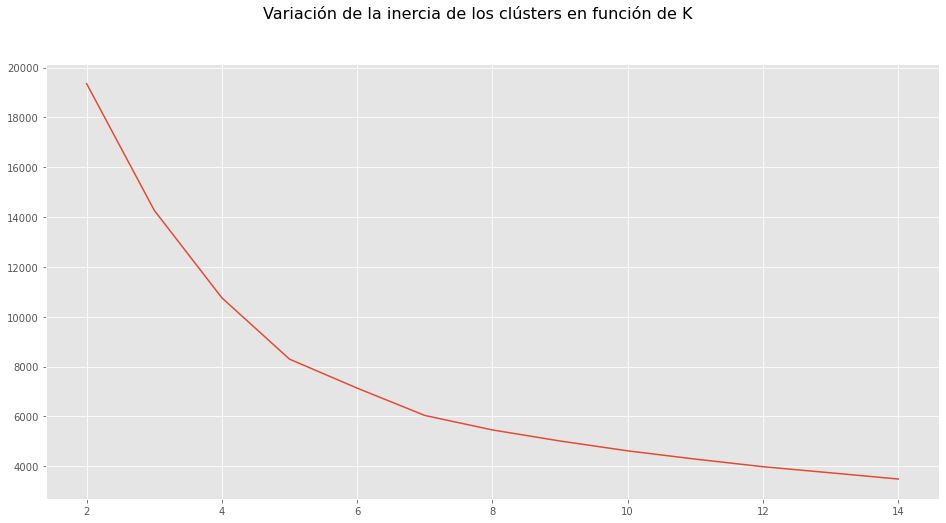

In [729]:
if CALCULATE_ELBOW:
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot()

    x_values = list(sse.keys())
    y_values = list(sse.values())

    ax.plot(x_values, y_values, label = "Inercia de los clústers")
    fig.suptitle("Variación de la inercia de los clústers en función de K", fontsize = 16)

### 4.3 Modelo K-MEANS

In [730]:
# Como ya tenemos un DF con los 10000 clientes y sus datos de interés para personalizar los correos, vamos a aplicar un KMeans para segmentarlos en 4 o 5 grupos:

pipe = Pipeline(steps = [
    #("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = ["salary"])),
    ("StandardScaler", StandardScaler()),
    ("Clustering", KMeans(n_clusters = 5))
])

In [731]:
pipe.fit(df_personal)
scaled_outliers_df = pipe["StandardScaler"].transform(df_personal)
scaled_outliers_df = pd.DataFrame(scaled_outliers_df, index = df_personal.index, columns = df_personal.columns)
scaled_outliers_df.head()

,gender,age,Tasa_desempleo,Población
pk_cid,,,,
673370,1.22,0.22,0.06,-0.43
679237,-0.82,1.77,0.06,-0.43
676923,-0.82,1.92,-0.88,-0.47
626474,-0.82,0.96,0.06,-0.43
625030,1.22,1.84,0.06,-0.43


In [732]:
# Calculamos el clúster para cada cliente:

labels = pipe["Clustering"].predict(scaled_outliers_df)
df_personal["cluster"] = labels
df_personal.head()

,gender,age,Tasa_desempleo,Población,cluster
pk_cid,,,,,
673370,1,40,15.45,"262,409.00",2
679237,0,61,15.45,"262,409.00",3
676923,0,63,10.83,"220,607.00",3
626474,0,50,15.45,"262,409.00",3
625030,1,62,15.45,"262,409.00",3


### 4.4 Ficha personalizada

In [733]:
ficha_personal = pd.DataFrame()

for i, col in enumerate([ "age", "gender", "Población", "Tasa_desempleo"]):
    resumen_personal = df_personal[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_personal = ficha_personal.append(resumen_personal)
    
ficha_personal.head(5)

cluster      0     1     2     3     4
age mean 33.11 34.22 32.43 62.27 34.11
    std   8.27 10.31  8.91 10.15 11.85
    min  20.00 20.00  9.00 49.00 20.00
    25%  26.00 25.00 24.00 54.00 24.75
    50%  33.00 33.00 32.00 60.00 31.50

In [734]:
# Multiíndice
new_index = [ "Edad", "Sexo", "Población", "Tasa de desempleo"]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

multi_index = []

for oi in new_index:
    for es in estadisticos:
        multi_index.append((oi, es))
        
multi_index

[('Edad', 'Media'),
 ('Edad', 'Desviación'),
 ('Edad', 'Mínimo'),
 ('Edad', 'Perc. 25'),
 ('Edad', 'Perc. 50'),
 ('Edad', 'Perc. 75'),
 ('Edad', 'Máximo'),
 ('Sexo', 'Media'),
 ('Sexo', 'Desviación'),
 ('Sexo', 'Mínimo'),
 ('Sexo', 'Perc. 25'),
 ('Sexo', 'Perc. 50'),
 ('Sexo', 'Perc. 75'),
 ('Sexo', 'Máximo'),
 ('Población', 'Media'),
 ('Población', 'Desviación'),
 ('Población', 'Mínimo'),
 ('Población', 'Perc. 25'),
 ('Población', 'Perc. 50'),
 ('Población', 'Perc. 75'),
 ('Población', 'Máximo'),
 ('Tasa de desempleo', 'Media'),
 ('Tasa de desempleo', 'Desviación'),
 ('Tasa de desempleo', 'Mínimo'),
 ('Tasa de desempleo', 'Perc. 25'),
 ('Tasa de desempleo', 'Perc. 50'),
 ('Tasa de desempleo', 'Perc. 75'),
 ('Tasa de desempleo', 'Máximo')]

In [735]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [736]:
names = ["Indicador", "Estadísticos"]
index_ficha = generate_multiindex(multi_index, names)
ficha_personal.set_index(index_ficha, inplace = True)

In [737]:
customer_per_cluster = df_personal.groupby("cluster").size().to_frame().T
customer_per_cluster.set_index(generate_multiindex([("Datos Generales", "Total de clientes")] , names), inplace = True)

In [738]:
ficha_personal = customer_per_cluster.append(ficha_personal)
ficha_personal

cluster                                        0            1            2  \
Indicador         Estadísticos                                               
Datos Generales   Total de clientes     2,484.00     1,052.00     1,799.00   
Edad              Media                    33.11        34.22        32.43   
                  Desviación                8.27        10.31         8.91   
                  Mínimo                   20.00        20.00         9.00   
                  Perc. 25                 26.00        25.00        24.00   
                  Perc. 50                 33.00        33.00        32.00   
                  Perc. 75                 40.00        41.00        39.00   
                  Máximo                   51.00        66.00        53.00   
Sexo              Media                     0.00         0.34         1.00   
                  Desviación                0.00         0.47         0.00   
                  Mínimo                    0.00         0.00         1.00   
                  Perc. 25                  0.00         0.00         1.00   
                  Perc. 50                  0.00         0.00         1.00   
                  Perc. 75                  0.00         1.00         1.00   
                  Máximo                    0.00         1.00         1.00   
Población         Media               482,143.75   884,408.58   492,946.54   
                  Desviación          459,855.87   520,398.09   466,934.91   
                  Mínimo               89,892.00    84,085.00    89,892.00   
                  Perc. 25            262,409.00   670,903.00   262,409.00   
                  Perc. 50            262,409.00   925,160.00   262,409.00   
                  Perc. 75            574,936.00 1,085,815.00   582,388.00   
                  Máximo            2,568,846.00 1,957,520.00 2,568,846.00   
Tasa de desempleo Media                    13.07        24.20        13.42   
                  Desviación                2.73         2.38         3.07   
                  Mínimo                    8.04        19.28         8.04   
                  Perc. 25                 10.83        21.96        10.83   
                  Perc. 50                 14.16        24.41        14.77   
                  Perc. 75                 15.45        25.94        15.45   
                  Máximo                   18.35        27.44        20.31   

cluster                                        3            4  
Indicador         Estadísticos                                 
Datos Generales   Total de clientes       861.00       256.00  
Edad              Media                    62.27        34.11  
                  Desviación               10.15        11.85  
                  Mínimo                   49.00        20.00  
                  Perc. 25                 54.00        24.75  
                  Perc. 50                 60.00        31.50  
                  Perc. 75                 68.00        41.00  
                  Máximo                   97.00        92.00  
Sexo              Media                     0.41         0.36  
                  Desviación                0.49         0.48  
                  Mínimo                    0.00         0.00  
                  Perc. 25                  0.00         0.00  
                  Perc. 50                  0.00         0.00  
                  Perc. 75                  1.00         1.00  
                  Máximo                    1.00         1.00  
Población         Media               465,984.11 5,900,061.12  
                  Desviación          423,946.73   474,661.97  
                  Mínimo               84,085.00 5,635,100.00  
                  Perc. 25            262,409.00 5,635,100.00  
                  Perc. 50            262,409.00 5,635,100.00  
                  Perc. 75            574,936.00 5,635,100.00  
                  Máximo            2,568,846.00 6,747,068.00  
Tasa de desempleo Media                    14